### Interperation of results

It is clear that the validation class 3 scores is always lower than the test class 3 score, which indicates that the presence of class 3 in validation is of a different type than the class 3 signals present in the test data. And the test data better aligns with the class 3 during training.

AUC: Measures the model’s ability to distinguish between classes. For multiclass, it's often macro-averaged one-vs-rest ROC AUC or PR AUC.

Probabilistic models where you care about confidence scores.

Situations where thresholding is flexible or you care about score calibration.

Often used in medical or risk assessment domains where ranking is more critical than classification labels.

describe the case where macro auc is decreasing while macro f1 is increasing for validation scores at the higher epochs of fine-tuning?

In [1]:
import os
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, average_precision_score
import pandas as pd
from collections import defaultdict, Counter

models = ['simclr', 'byol', 'swav']

# Map the parameters to their corresponding estimated strength values
param_map = { 
    # Dynamic Time Warping (DTW) parameters, w is the number of segments, r is the warp percentage
    'DTW_w=1_r=10': 1, # total 10% stretch / squeeze
    'DTW_w=3_r=5': 2, # total 15%
    'DTW_w=3_r=10': 3, # total 30%
    # TimeOut / Masking (TO) parameters, choose a random value between the specified range to zero out
    'TO_crop_ratio_range=[0.1, 0.2]': 1, # average 15% masked
    'TO_crop_ratio_range=[0.0, 0.5]': 2, # average 25% masked
    'TO_crop_ratio_range=[0.4, 0.5]': 3, # average 45% masked
    # Gaussian Noise (GN) parameters, var is the variance of the noise
    'GN_var=0.01': 1, 
    'GN_var=0.1': 2, 
    'GN_var=1.0': 3,
    # Channel Resize (ChR) parameters, magnitude_range is the range from which a scale factor is uniformly sampled
    'ChR_magnitude_range=[0.33, 1.0]': 1, # average c=0.66
    'ChR_magnitude_range=[0.5, 2.0]': 2, # average c=1.25
    'ChR_magnitude_range=[0.33, 3.0]': 3, # average c=1.66
    # Electromyographic Noise (EM) paramers, var is the variance of the noise
    'EM_var=0.01': 1, 
    'EM_var=0.5': 2,
    'EM_var=1.0': 3,
    # Negation (Neg), Flip the signal around the x-axis
    'Neg_True': 2,
    # Baseline wander (BW), paramers fs is sample frequency and c is the amplitude coefficient
    'BlW_fs=100_C=0.1':1, 
    'BlW_fs=100_C=0.7':2, 
    'BlW_fs=100_C=1.0':3
} 

finetune_rows = []
linear_eval_rows = []

table_ft_rows = []
table_eval_rows = []

def get_class_accuracies(y_true, y_pred):
    num_classes = np.max(y_true) + 1
    accuracies = []
    for c in range(num_classes):
        mask = y_true == c
        acc = accuracy_score(y_true[mask], y_pred[mask]) if np.any(mask) else 0.0
        accuracies.append(acc)
    return accuracies
correct_dict = defaultdict(dict)
# Iterate through models
for model in models:
    path = f'evaluation_logs/new_runs/{model}'
    if not os.path.exists(path):
        continue
    
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if not os.path.isdir(folder_path):
            continue

        if 'finetuned' in folder.split("_"):
            run_type = 'finetuned'
        elif 'linear' in folder.split("_"):
            run_type = 'linear'
        else:
            continue
        
        result_file = f"result_{run_type}.pkl"
        result_path = os.path.join(folder_path, result_file)

        if not os.path.isfile(result_path):
            print(f"Warning: {result_file} not found in {folder_path}")
            continue

        with open(result_path, 'rb') as f:
            result_dict = pickle.load(f)

        run_name = result_dict.get('run_name')
        aug = run_name.split('_')[1] if run_name else "unknown"
        parameters = '_'.join(run_name.split('_')[2:-1]) if run_name else "unknown"
        run_names = aug + '_' + parameters 
        strength = param_map.get(run_names, 0)
        val_macro_f1 = result_dict.get('result_macros')[0]
        test_macro_f1 = result_dict.get('test_macros')[0]

        val_preds, test_preds = result_dict['predss'][0]
        val_ytrue, test_ytrue = result_dict['true_labels'][0]

        # Save raw probabilities before argmax
        test_probs = test_preds.copy()

        val_preds = np.argmax((val_preds > 0.5).astype(int), axis=1)
        test_preds = np.argmax((test_preds > 0.5).astype(int), axis=1)
        val_ytrue = np.argmax(val_ytrue, axis=1)
        test_ytrue = np.argmax(test_ytrue, axis=1)

        val_accs = get_class_accuracies(val_ytrue, val_preds)
        test_accs = get_class_accuracies(test_ytrue, test_preds)
        
        row = [
            model,
            aug,
            str(parameters),
            strength,
            val_macro_f1,
            *val_accs,
            test_macro_f1,
            *test_accs
        ]

        # Validation classification report
        val_report = classification_report(val_ytrue, val_preds, output_dict=True, zero_division=0)

        val_macro_avg_f1 = round(val_report['macro avg']['f1-score'] * 100, 2)
        val_macro_avg_prec = round(val_report['macro avg']['precision'] * 100, 2)
        val_macro_avg_rc = round(val_report['macro avg']['recall'] * 100, 2)

        # Class-wise validation metrics
        val_f1_c1 = round(val_report['0']['f1-score'] * 100, 2)
        val_prec_c1 = round(val_report['0']['precision'] * 100, 2)
        val_rc_c1 = round(val_report['0']['recall'] * 100, 2)

        val_f1_c2 = round(val_report['1']['f1-score'] * 100, 2)
        val_prec_c2 = round(val_report['1']['precision'] * 100, 2)
        val_rc_c2 = round(val_report['1']['recall'] * 100, 2)

        val_f1_c3 = round(val_report['2']['f1-score'] * 100, 2) if '2' in val_report else 0.0
        val_prec_c3 = round(val_report['2']['precision'] * 100, 2) if '2' in val_report else 0.0
        val_rc_c3 = round(val_report['2']['recall'] * 100, 2) if '2' in val_report else 0.0


        # Classification report test
        test_report = classification_report(test_ytrue, test_preds, output_dict=True, zero_division=0)
        test_macro_avg_f1 = round(test_report['macro avg']['f1-score'] * 100, 2)
        test_macro_avg_prec = round(test_report['macro avg']['precision'] * 100, 2)
        test_macro_avg_rc = round(test_report['macro avg']['recall'] * 100, 2)

        # Extract class-wise F1, Precision, Recall
        test_f1_c1 = round(test_report['0']['f1-score'] * 100, 2)
        test_prec_c1 = round(test_report['0']['precision'] * 100, 2)
        test_rc_c1 = round(test_report['0']['recall'] * 100, 2)

        test_f1_c2 = round(test_report['1']['f1-score'] * 100, 2)
        test_prec_c2 = round(test_report['1']['precision'] * 100, 2)
        test_rc_c2 = round(test_report['1']['recall'] * 100, 2)

        test_f1_c3 = round(test_report['2']['f1-score'] * 100, 2) if '2' in test_report else 0.0
        test_prec_c3 = round(test_report['2']['precision'] * 100, 2) if '2' in test_report else 0.0
        test_rc_c3 = round(test_report['2']['recall'] * 100, 2) if '2' in test_report else 0.0

        # Calculate PR AUC for each class
        pr_aucs = []
        for c in range(3):
            try:
                y_true_binary = (test_ytrue == c).astype(int)
                y_prob = test_probs[:, c]
                pr_auc = average_precision_score(y_true_binary, y_prob)
                pr_aucs.append(round(pr_auc * 100, 2))
            except Exception:
                pr_aucs.append(0.0)

        test_pr_auc_c1, test_pr_auc_c2, test_pr_auc_c3 = pr_aucs

        # Add row
        res_rows = ([
            model,
            aug,
            str(parameters),
            strength,
            test_macro_avg_f1,
            test_macro_avg_prec,
            test_macro_avg_rc,
            test_f1_c1,
            test_prec_c1,
            test_rc_c1,
            test_pr_auc_c1,
            test_f1_c2,
            test_prec_c2,
            test_rc_c2,
            test_pr_auc_c2,
            test_f1_c3,
            test_prec_c3,
            test_rc_c3,
            test_pr_auc_c3,
            val_macro_avg_f1,
            val_macro_avg_prec,
            val_macro_avg_rc,
            val_f1_c1,
            val_prec_c1,
            val_rc_c1,
            val_f1_c2,
            val_prec_c2,
            val_rc_c2,
            val_f1_c3,
            val_prec_c3,
            val_rc_c3
        ])


        if result_dict.get('linear_evaluation'):
            linear_eval_rows.append(row)
            table_eval_rows.append(res_rows)
        else:
            finetune_rows.append(row)
            table_ft_rows.append(res_rows)
        correct_dict[run_type][model + '_' + run_names] = {'val': (val_preds == val_ytrue, val_preds), 'test': (test_preds == test_ytrue, test_preds)}
        

# DataFrames
columns = [
    'model', 'augmentation', 'parameters', 'aug_strength',
    'val_macro_f1', 'val_acc_class1', 'val_acc_class2', 'val_acc_class3',
    'test_macro_f1', 'test_acc_class1', 'test_acc_class2', 'test_acc_class3',
]

finetune_df = pd.DataFrame(finetune_rows, columns=columns)
linear_eval_df = pd.DataFrame(linear_eval_rows, columns=columns)

res_cols = [
    'model', 'augmentation', 'parameters', 'aug_strength',
    'test_avg_f1', 'test_avg_prec', 'test_avg_rc',
    'test_f1_class1', 'test_prec_class1', 'test_rc_class1', 'test_pr_auc_class1',
    'test_f1_class2', 'test_prec_class2', 'test_rc_class2', 'test_pr_auc_class2',
    'test_f1_class3', 'test_prec_class3', 'test_rc_class3', 'test_pr_auc_class3',
    'val_avg_f1', 'val_avg_prec', 'val_avg_rc',
    'val_f1_class1', 'val_prec_class1', 'val_rc_class1',
    'val_f1_class2', 'val_prec_class2', 'val_rc_class2',
    'val_f1_class3', 'val_prec_class3', 'val_rc_class3'
]

ft_res_df = pd.DataFrame(table_ft_rows, columns=res_cols)
le_res_df = pd.DataFrame(table_eval_rows, columns=res_cols)





In [2]:
print('FINETUNED')
print(f"Mean Validation Macro F1: {finetune_df.val_macro_f1.mean():.4f}")
print(f"Mean Test Macro F1: {finetune_df.test_macro_f1.mean():.4f}")
print(f"Class 3 - Val - Accuracy: {finetune_df.val_acc_class3.mean():.4f}")
print(f"Class 3 - Test - Accuracy: {finetune_df.test_acc_class3.mean():.4f}")
finetune_df.sort_values(by='test_macro_f1', ascending=False).head()

FINETUNED
Mean Validation Macro F1: 0.5504
Mean Test Macro F1: 0.7702
Class 3 - Val - Accuracy: 0.0422
Class 3 - Test - Accuracy: 0.5252


,model,augmentation,parameters,aug_strength,val_macro_f1,val_acc_class1,val_acc_class2,val_acc_class3,test_macro_f1,test_acc_class1,test_acc_class2,test_acc_class3
4,simclr,TO,"crop_ratio_range=[0.1, 0.2]",1,0.555570,0.967312,0.625982,0.040188,0.835802,0.899692,0.780490,0.713274
42,swav,TO,"crop_ratio_range=[0.4, 0.5]",3,0.559828,0.954022,0.678007,0.036839,0.834378,0.861923,0.847673,0.675221
3,simclr,TO,"crop_ratio_range=[0.4, 0.5]",3,0.551195,0.961524,0.660359,0.024782,0.828534,0.898385,0.764980,0.682301
9,simclr,ChR,"magnitude_range=[0.33, 1.0]",1,0.569004,0.959273,0.684637,0.024113,0.827948,0.904923,0.750286,0.713274
23,byol,TO,"crop_ratio_range=[0.4, 0.5]",3,0.561191,0.972992,0.649087,0.054253,0.827285,0.902269,0.756408,0.706195


In [3]:
print('\nLINEAR EVALUATION')
print(f"Mean Validation Macro F1: {linear_eval_df.val_macro_f1.mean():.4f}")
print(f"Mean Test Macro F1: {linear_eval_df.test_macro_f1.mean():.4f}")
print(f"Class 3 - Val - Accuracy: {linear_eval_df.val_acc_class3.mean():.4f}")
print(f"Class 3 - Test - Accuracy: {linear_eval_df.test_acc_class3.mean():.4f}")
linear_eval_df.sort_values(by='val_acc_class3', ascending=False).head()


LINEAR EVALUATION
Mean Validation Macro F1: 0.4835
Mean Test Macro F1: 0.7349
Class 3 - Val - Accuracy: 0.0231
Class 3 - Test - Accuracy: 0.5152


,model,augmentation,parameters,aug_strength,val_macro_f1,val_acc_class1,val_acc_class2,val_acc_class3,test_macro_f1,test_acc_class1,test_acc_class2,test_acc_class3
48,swav,ChR,"magnitude_range=[0.33, 1.0]",1,0.560581,0.955683,0.459400,0.168788,0.659883,0.711500,0.810939,0.318584
41,swav,TO,"crop_ratio_range=[0.1, 0.2]",1,0.527375,0.935641,0.486739,0.154722,0.779307,0.816038,0.756082,0.606195
50,swav,EM,var=0.01,1,0.493245,0.952146,0.468938,0.041527,0.732441,0.865192,0.616490,0.557522
28,byol,ChR,"magnitude_range=[0.33, 1.0]",1,0.457643,0.974867,0.380649,0.037508,0.736967,0.954038,0.426204,0.705310
46,swav,GN,var=1.0,3,0.500027,0.936391,0.503570,0.037508,0.734774,0.842077,0.662694,0.515929


In [4]:
model_order = ["simclr", "byol", "swav"]
le_res_df["model"] = pd.Categorical(le_res_df["model"], categories=model_order, ordered=True)

df_sorted = le_res_df.sort_values(by=["model", "augmentation", "aug_strength"])
df_sorted.to_csv('linear_evaluation_results.csv', index=False)

In [5]:
df_sorted

,model,augmentation,parameters,aug_strength,test_avg_f1,test_avg_prec,test_avg_rc,test_f1_class1,test_prec_class1,test_rc_class1,...,val_avg_rc,val_f1_class1,val_prec_class1,val_rc_class1,val_f1_class2,val_prec_class2,val_rc_class2,val_f1_class3,val_prec_class3,val_rc_class3
16,simclr,BlW,fs=100_C=0.1,1,69.90,86.69,63.39,87.45,81.13,94.84,...,48.23,75.55,61.53,97.83,61.25,90.35,46.33,1.05,21.05,0.54
17,simclr,BlW,fs=100_C=0.7,2,73.10,86.70,66.79,88.20,82.64,94.57,...,49.25,76.04,62.18,97.85,62.33,90.45,47.55,4.43,39.77,2.34
18,simclr,BlW,fs=100_C=1.0,3,74.23,86.14,68.14,87.61,81.97,94.07,...,48.36,75.71,61.88,97.51,61.16,88.80,46.65,1.81,25.93,0.94
9,simclr,ChR,"magnitude_range=[0.33, 1.0]",1,80.00,86.39,75.58,88.03,84.38,92.01,...,47.96,74.98,60.60,98.29,58.31,90.08,43.11,4.61,32.74,2.48
11,simclr,ChR,"magnitude_range=[0.5, 2.0]",2,78.09,87.64,72.51,88.17,82.52,94.66,...,48.05,75.00,60.69,98.13,59.13,90.40,43.94,4.00,53.45,2.08
10,simclr,ChR,"magnitude_range=[0.33, 3.0]",3,79.47,85.93,75.23,88.01,87.00,89.04,...,47.59,74.54,60.14,98.02,57.55,89.59,42.39,4.49,53.03,2.34
1,simclr,DTW,w=1_r=10,1,71.71,86.39,65.23,87.03,79.84,95.64,...,48.24,75.47,61.39,97.93,60.15,89.48,45.30,2.82,33.85,1.47
0,simclr,DTW,w=3_r=5,2,72.01,85.04,65.95,87.89,82.22,94.40,...,49.00,76.11,62.38,97.59,62.68,89.76,48.15,2.47,39.58,1.27
2,simclr,DTW,w=3_r=10,3,65.87,85.87,59.69,86.42,80.05,93.89,...,47.53,74.79,60.87,96.96,59.11,87.56,44.61,1.95,34.88,1.00
13,simclr,EM,var=0.01,1,72.82,87.05,66.35,87.93,81.89,94.93,...,47.87,75.18,61.06,97.79,59.88,89.60,44.97,1.70,35.14,0.87


In [6]:
# best test augmentation per model based on test_macro_f1
best_df = ft_res_df.loc[ft_res_df.groupby('model')['test_avg_f1'].idxmax()]
best_df
# best_df

,model,augmentation,parameters,aug_strength,test_avg_f1,test_avg_prec,test_avg_rc,test_f1_class1,test_prec_class1,test_rc_class1,...,val_avg_rc,val_f1_class1,val_prec_class1,val_rc_class1,val_f1_class2,val_prec_class2,val_rc_class2,val_f1_class3,val_prec_class3,val_rc_class3
23,byol,TO,"crop_ratio_range=[0.4, 0.5]",3,82.61,87.95,78.83,89.47,88.73,90.23,...,55.88,82.42,71.49,97.30,75.59,90.49,64.91,9.05,27.27,5.43
4,simclr,TO,"crop_ratio_range=[0.1, 0.2]",1,83.43,88.66,79.78,89.83,89.68,89.97,...,54.45,81.24,70.03,96.73,73.51,89.03,62.60,7.10,30.30,4.02
42,swav,TO,"crop_ratio_range=[0.4, 0.5]",3,82.59,88.16,79.49,89.15,92.31,86.19,...,55.63,82.24,72.27,95.40,76.74,88.40,67.80,6.96,63.22,3.68


In [7]:
# best test augmentation per model based on test_macro_f1
le_best_df = le_res_df.loc[ft_res_df.groupby('model')['test_avg_f1'].idxmax()]

le_best_df
# why channel resize the best for linear eval? because it makes signals similar to the flatline noise in the testset?

,model,augmentation,parameters,aug_strength,test_avg_f1,test_avg_prec,test_avg_rc,test_f1_class1,test_prec_class1,test_rc_class1,...,val_avg_rc,val_f1_class1,val_prec_class1,val_rc_class1,val_f1_class2,val_prec_class2,val_rc_class2,val_f1_class3,val_prec_class3,val_rc_class3
23,byol,TO,"crop_ratio_range=[0.4, 0.5]",3,76.01,86.26,70.62,87.24,80.24,95.59,...,47.47,75.04,60.92,97.67,58.16,87.85,43.47,2.32,13.38,1.27
4,simclr,TO,"crop_ratio_range=[0.1, 0.2]",1,76.99,85.26,72.14,86.81,85.70,87.95,...,49.44,76.51,63.90,95.31,63.96,84.78,51.35,3.24,48.08,1.67
42,swav,TO,"crop_ratio_range=[0.4, 0.5]",3,75.19,85.40,70.48,86.89,87.98,85.83,...,50.93,77.04,64.10,96.52,66.22,89.21,52.65,6.83,60.67,3.62


### Validation best augmentations

In [8]:
# validation fine-tune best test augmentation per model based on test_macro_f1
ft_best_val_df = ft_res_df.loc[ft_res_df.groupby('model')['val_avg_f1'].idxmax()]

# validation set is the cluster which should have more complex class 3 than test set
# if simple resizing the signal is most effective, this would not better align the signals with the complex class 3 of validation set so unclear
# But it does align better to some of the flatlines...
ft_best_val_df[['model', 'augmentation', 'parameters'] + [c for c in ft_best_val_df.columns if 'val' in c]]
# ft_res_df[['model', 'augmentation', 'parameters'] + [c for c in ft_res_df.columns if 'val' in c]].loc[(ft_res_df.augmentation == 'TO') & (ft_res_df.parameters == 'crop_ratio_range=[0.1, 0.2]')]

,model,augmentation,parameters,val_avg_f1,val_avg_prec,val_avg_rc,val_f1_class1,val_prec_class1,val_rc_class1,val_f1_class2,val_prec_class2,val_rc_class2,val_f1_class3,val_prec_class3,val_rc_class3
29,byol,ChR,"magnitude_range=[0.33, 3.0]",58.28,77.52,57.88,84.24,75.16,95.80,79.30,88.73,71.69,11.31,68.66,6.16
10,simclr,ChR,"magnitude_range=[0.33, 3.0]",58.76,70.24,58.32,84.67,77.49,93.31,80.53,86.46,75.35,11.10,46.77,6.30
48,swav,ChR,"magnitude_range=[0.33, 1.0]",57.22,61.82,56.88,80.97,70.41,95.25,72.99,88.45,62.13,17.70,26.61,13.26


In [18]:
# Get top 5 configurations per model based on test_macro_f1
top5_per_model = (
    ft_res_df
    .sort_values(by='val_avg_f1', ascending=False)
    .groupby('model')
    .head(5)
)

# Display selected columns for review
top5_per_model[['model', 'augmentation', 'parameters'] + [c for c in top5_per_model.columns if 'val' in c ]].sort_values(by=['model', 'val_avg_f1'], ascending=False)


,model,augmentation,parameters,val_avg_f1,val_avg_prec,val_avg_rc,val_f1_class1,val_prec_class1,val_rc_class1,val_f1_class2,val_prec_class2,val_rc_class2,val_f1_class3,val_prec_class3,val_rc_class3
48,swav,ChR,"magnitude_range=[0.33, 1.0]",57.22,61.82,56.88,80.97,70.41,95.25,72.99,88.45,62.13,17.70,26.61,13.26
41,swav,TO,"crop_ratio_range=[0.1, 0.2]",55.97,57.81,60.46,81.82,72.89,93.24,66.47,86.82,53.85,19.61,13.73,34.29
47,swav,ChR,"magnitude_range=[0.33, 3.0]",55.48,69.46,55.84,82.87,73.49,95.01,77.06,87.19,69.05,6.49,47.71,3.48
42,swav,TO,"crop_ratio_range=[0.4, 0.5]",55.31,74.63,55.63,82.24,72.27,95.40,76.74,88.40,67.80,6.96,63.22,3.68
43,swav,TO,"crop_ratio_range=[0.0, 0.5]",55.10,66.01,55.53,82.51,72.67,95.43,76.52,87.87,67.76,6.26,37.50,3.42
10,simclr,ChR,"magnitude_range=[0.33, 3.0]",58.76,70.24,58.32,84.67,77.49,93.31,80.53,86.46,75.35,11.10,46.77,6.30
5,simclr,TO,"crop_ratio_range=[0.0, 0.5]",55.86,71.51,55.85,82.14,71.39,96.71,75.57,89.48,65.40,9.85,53.64,5.43
9,simclr,ChR,"magnitude_range=[0.33, 1.0]",54.91,83.77,55.60,82.92,73.01,95.93,77.12,88.29,68.46,4.70,90.00,2.41
14,simclr,EM,var=1.0,54.83,76.97,55.39,82.48,72.52,95.61,76.49,87.92,67.69,5.53,70.49,2.88
15,simclr,Neg,True,54.66,75.96,54.63,80.40,68.51,97.28,72.71,90.62,60.72,10.86,68.75,5.89


In [9]:
ft_res_df.loc[ft_res_df.groupby('model')['val_avg_f1'].idxmax()]

,model,augmentation,parameters,aug_strength,test_avg_f1,test_avg_prec,test_avg_rc,test_f1_class1,test_prec_class1,test_rc_class1,...,val_avg_rc,val_f1_class1,val_prec_class1,val_rc_class1,val_f1_class2,val_prec_class2,val_rc_class2,val_f1_class3,val_prec_class3,val_rc_class3
29,byol,ChR,"magnitude_range=[0.33, 3.0]",3,78.62,87.75,73.97,89.42,89.93,88.92,...,57.88,84.24,75.16,95.80,79.30,88.73,71.69,11.31,68.66,6.16
10,simclr,ChR,"magnitude_range=[0.33, 3.0]",3,78.65,85.91,75.51,86.36,91.81,81.53,...,58.32,84.67,77.49,93.31,80.53,86.46,75.35,11.10,46.77,6.30
48,swav,ChR,"magnitude_range=[0.33, 1.0]",1,80.77,86.90,76.64,89.19,87.98,90.43,...,56.88,80.97,70.41,95.25,72.99,88.45,62.13,17.70,26.61,13.26


In [10]:
# choose FT scores based on augmentations shown in testing results
best_df[['model', 'augmentation', 'parameters'] + [c for c in best_df.columns if 'val' in c]]

,model,augmentation,parameters,val_avg_f1,val_avg_prec,val_avg_rc,val_f1_class1,val_prec_class1,val_rc_class1,val_f1_class2,val_prec_class2,val_rc_class2,val_f1_class3,val_prec_class3,val_rc_class3
23,byol,TO,"crop_ratio_range=[0.4, 0.5]",55.69,63.08,55.88,82.42,71.49,97.30,75.59,90.49,64.91,9.05,27.27,5.43
4,simclr,TO,"crop_ratio_range=[0.1, 0.2]",53.95,63.12,54.45,81.24,70.03,96.73,73.51,89.03,62.60,7.10,30.30,4.02
42,swav,TO,"crop_ratio_range=[0.4, 0.5]",55.31,74.63,55.63,82.24,72.27,95.40,76.74,88.40,67.80,6.96,63.22,3.68


### LE PLOT

RGB and HEX values:
Color 1: RGB = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725), HEX = #4c72b0
Color 2: RGB = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), HEX = #dd8452
Color 3: RGB = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), HEX = #55a868
Color 4: RGB = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), HEX = #c44e52
Color 5: RGB = (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), HEX = #8172b3
Color 6: RGB = (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), HEX = #937860
Color 7: RGB = (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), HEX = #da8bc3
Color 8: RGB = (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), HEX = #8c8c8c
Color 9: RGB = (0.8, 0.7254901960784313, 0.4549019607843137), HEX = #ccb974
Color 10: RGB = (0.39215686274509803, 0.7098039215686275, 0.803921568627451), HEX = #64b5cd


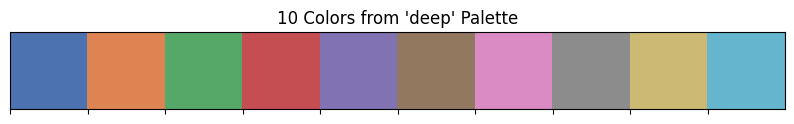

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# Extract 10 colors from the 'deep' palette
colors = sns.color_palette("deep", 10)

# Convert RGB to HEX using matplotlib
hex_colors = [to_hex(c) for c in colors]

# Print both RGB and HEX
print("RGB and HEX values:")
for i, (rgb, hex_color) in enumerate(zip(colors, hex_colors), 1):
    print(f"Color {i}: RGB = {rgb}, HEX = {hex_color}")

# Visualize palette
sns.palplot(colors)
plt.title("10 Colors from 'deep' Palette")
plt.show()


(66.5895, 81.1205) (0.2360000000000002, 86.34400000000001)


KeyboardInterrupt: 

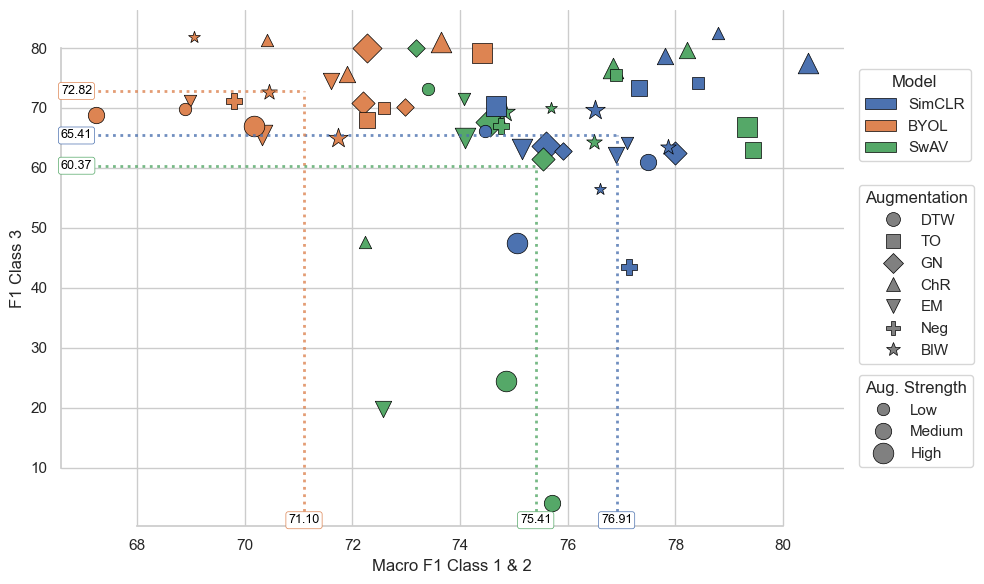

In [12]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Compute macro avg PR AUC for classes 1 & 2
# ft_res_df['test_pr_auc_class12'] = (ft_res_df.test_pr_auc_class1 + ft_res_df.test_pr_auc_class2) / 2

le_res_df['test_f1_class12'] = (le_res_df.test_f1_class1  + le_res_df.test_f1_class2) /2
# print(num_class1, num_class2)

# Plot style
sns.set(style='whitegrid')

# Set color and marker dictionaries
model_palette = sns.color_palette('deep', n_colors=le_res_df['model'].nunique())
model_colors = dict(zip(le_res_df['model'].unique(), model_palette))

augmentations = le_res_df['augmentation'].unique()
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
marker_dict = dict(zip(augmentations, markers))

# Map size values first (e.g., using your size_map)
size_map = {1: 80, 2: 140, 3: 220}
le_res_df['plot_size'] = le_res_df['aug_strength'].map(size_map)

# Sort so large points are plotted first
plot_df = le_res_df.sort_values('plot_size', ascending=False)

# Plot
# x_col = 'test_pr_auc_class12'
# y_col = 'test_pr_auc_class3'
x_col = 'test_f1_class12'
y_col = 'test_f1_class3'

fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

for _, row in plot_df.iterrows():
    ax.scatter(
        row[x_col],
        row[y_col],
        color=model_colors[row['model']],
        marker=marker_dict[row['augmentation']],
        edgecolor='black',
        s=row['plot_size'],
        linewidth=0.5
    )

# Legend for models (colors)
model_display_names = {
    'simclr': 'SimCLR',
    'byol': 'BYOL',
    'swav': 'SwAV'
}

model_handles = [
    mpatches.Patch(facecolor=color, label=model_display_names.get(model, model), edgecolor='black', linewidth=0.5)
    for model, color in model_colors.items()
]

# Legend for augmentation strength (point size)
strength_labels = {1: 'Low', 2: 'Medium', 3: 'High'}
strength_handles = [
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                  markersize=(size_map[strength] ** 0.5),  # matplotlib scales s as area
                  label=label,
                  markeredgecolor='black', markeredgewidth=0.5)
    for strength, label in strength_labels.items()
]

# Place third legend
third_legend = plt.legend(handles=strength_handles, title='Aug. Strength', loc='lower left', bbox_to_anchor=(1.01, 0.1))
plt.gca().add_artist(third_legend)

# Legend for augmentations (markers)
augmentation_handles = [
    mlines.Line2D([], [], color='gray', marker=marker_dict[aug], linestyle='None',
                  markersize=10, label=aug, 
                  markeredgecolor='black', markeredgewidth=0.5)
    for aug in augmentations
]

# Place legends
first_legend = plt.legend(handles=model_handles, title='Model', loc='upper left', bbox_to_anchor=(1.01, 0.9))
second_legend = plt.legend(handles=augmentation_handles, title='Augmentation', loc='lower left', bbox_to_anchor=(1.01, 0.3))
plt.gca().add_artist(first_legend)  # Ensure both legends are shown

x_limits = ax.get_xlim()
y_limits = ax.get_ylim()
print(x_limits, y_limits)
# Draw dotted lines and annotate mean values for each model
for model in le_res_df['model'].unique():
    model_data = le_res_df[le_res_df['model'] == model]
    x_mean = model_data[x_col].mean()
    y_mean = model_data[y_col].mean()
    color = model_colors[model]

    
    # Vertical dotted line from bottom to the intersection point
    ax.plot([x_mean, x_mean], [y_limits[0], y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)

    # Horizontal dotted line from left to the intersection point
    ax.plot([x_limits[0], x_mean], [y_mean, y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)


    # Annotate at axis intersections with background
    ax.text(
        x_mean, y_limits[0], f'{x_mean:.2f}', color='black',
        fontsize=9, ha='center', va='bottom',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )

    ax.text(
        x_limits[0], y_mean, f'{y_mean:.2f}', color='black',
        fontsize=9, ha='left', va='center',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)



# Axis labels and title
plt.xlabel(f'Macro F1 Class 1 & 2', fontsize=12)
plt.ylabel(f'F1 Class 3', fontsize=12) # Macro F1 class 3
# plt.title(f'Linear Evaluation: F1-Score for Class 3 vs Class 1 & 2', fontsize=14)

# Final adjustments
sns.despine(trim=True)
plt.tight_layout()
plt.savefig(f"../images/augmentations/linear_f1_class3_vs_rest.pdf", dpi=300)
plt.show()


In [ ]:
print(x_limits, y_limits)

(66.5895, 81.1205) (0.2360000000000002, 86.34400000000001)


### FT PLOT

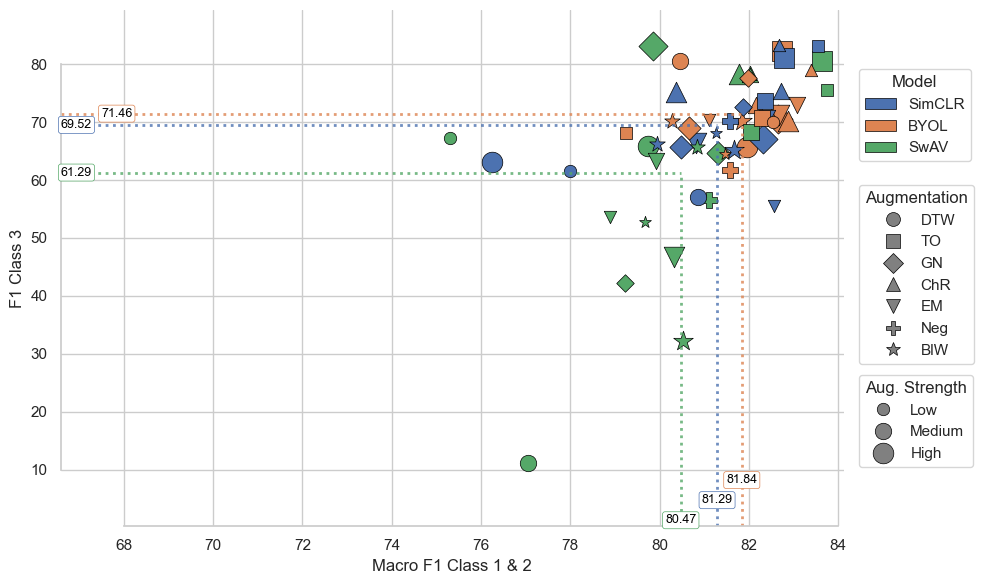

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np

# Assume num_class1 and num_class2 already computed macro is just non weighted average
ft_res_df['test_f1_class12'] = (ft_res_df.test_f1_class1+ ft_res_df.test_f1_class2) /2

# Style
sns.set(style='whitegrid')

# Color and marker settings
model_palette = sns.color_palette('deep', n_colors=ft_res_df['model'].nunique())
model_colors = dict(zip(ft_res_df['model'].unique(), model_palette))

augmentations = ft_res_df['augmentation'].unique()
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
marker_dict = dict(zip(augmentations, markers))

# Size
size_map = {1: 80, 2: 140, 3: 220}
ft_res_df['plot_size'] = ft_res_df['aug_strength'].map(size_map)

ft_plot_df = ft_res_df.sort_values('plot_size', ascending=False)

x_col = 'test_f1_class12'
y_col = 'test_f1_class3'

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
for _, row in ft_plot_df.iterrows():
    ax.scatter(
        row[x_col],
        row[y_col],
        color=model_colors[row['model']],
        marker=marker_dict[row['augmentation']],
        edgecolor='black',
        s=row['plot_size'],
        linewidth=0.5,
        alpha=1
    )

# Match linear plot axis ranges
ax.set_xlim(x_limits + np.array([0, 3]))
ax.set_ylim(y_limits + np.array([0, 3]))

# Legend for models (colors)
model_display_names = {
    'simclr': 'SimCLR',
    'byol': 'BYOL',
    'swav': 'SwAV'
}

model_handles = [
    mpatches.Patch(facecolor=color, label=model_display_names.get(model, model), edgecolor='black', linewidth=0.5)
    for model, color in model_colors.items()
]

# Legend for augmentation strength (point size)
strength_labels = {1: 'Low', 2: 'Medium', 3: 'High'}
strength_handles = [
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                  markersize=(size_map[strength] ** 0.5),  # matplotlib scales s as area
                  label=label,
                  markeredgecolor='black', markeredgewidth=0.5)
    for strength, label in strength_labels.items()
]

# Place third legend
third_legend = plt.legend(handles=strength_handles, title='Aug. Strength', loc='lower left', bbox_to_anchor=(1.01, 0.1))
plt.gca().add_artist(third_legend)

# Legend for augmentations (markers)
augmentation_handles = [
    mlines.Line2D([], [], color='gray', marker=marker_dict[aug], linestyle='None',
                  markersize=10, label=aug, 
                  markeredgecolor='black', markeredgewidth=0.5)
    for aug in augmentations
]

# Place legends
first_legend = plt.legend(handles=model_handles, title='Model', loc='upper left', bbox_to_anchor=(1.01, 0.9))
second_legend = plt.legend(handles=augmentation_handles, title='Augmentation', loc='lower left', bbox_to_anchor=(1.01, 0.3))
plt.gca().add_artist(first_legend)  # Ensure both legends are shown

# draw mean lines
for i, model in enumerate(['swav', 'simclr', 'byol']):
    model_data = ft_plot_df[ft_plot_df['model'] == model]
    x_mean = model_data[x_col].mean()
    y_mean = model_data[y_col].mean()
    color = model_colors[model]

    
    # Vertical dotted line from bottom to the intersection point
    ax.plot([x_mean, x_mean], [y_limits[0], y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)

    # Horizontal dotted line from left to the intersection point
    ax.plot([x_limits[0], x_mean], [y_mean, y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)


    # Annotate at axis intersections with background
    ax.text(
        x_mean, y_limits[0]+(y_limits[0] + y_limits[1])*i*0.04, f'{x_mean:.2f}', color='black',
        fontsize=9, ha='center', va='bottom',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )

    ax.text(
        x_limits[0] if i != 2 else x_limits[0] + 0.9, 
        y_mean, f'{y_mean:.2f}', 
        color='black',
        fontsize=9, ha='left', va='center',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )


# Labels and formatting
ax.set_xlabel('Macro F1 Class 1 & 2', fontsize=12)
ax.set_ylabel('F1 Class 3', fontsize=12)
# ax.set_title('Fine-tuned: Macro F1 vs Class 3 F1', fontsize=14)

sns.despine(trim=True)
plt.tight_layout()
plt.savefig(f"../images/augmentations/finetuned_f1_class3_vs_rest.pdf", dpi=300)
plt.show()


### Combined FT and Linear

Too cluttered

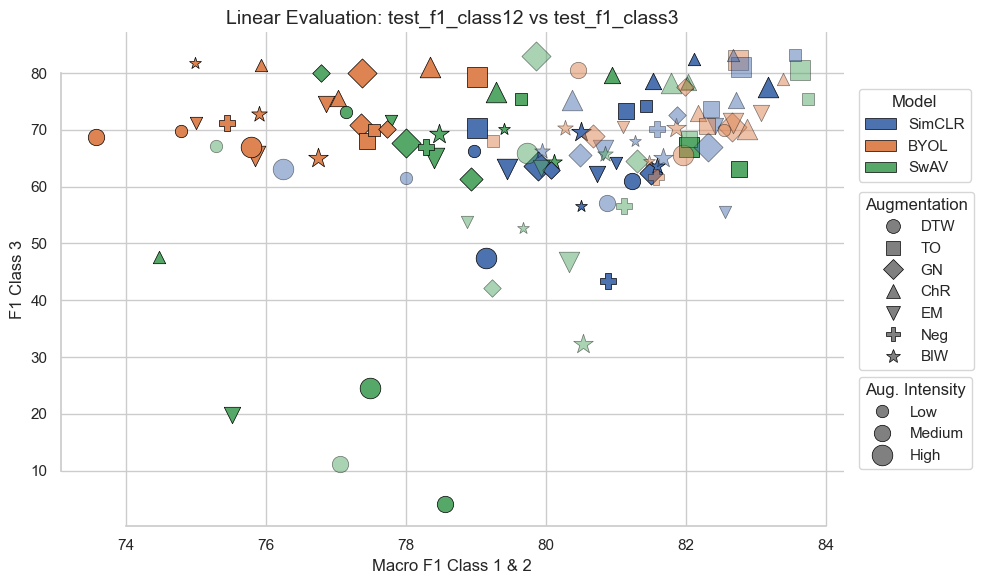

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Compute average PR AUC for classes 1 & 2
# le_res_df['test_pr_auc_class12'] = (le_res_df.test_pr_auc_class1 + le_res_df.test_pr_auc_class2) / 2
# macro avg is weighted with the number of samples in each class
test_class_counts = Counter(test_ytrue)
num_class1 = test_class_counts[0]
num_class2 = test_class_counts[1]
le_res_df['test_f1_class12'] = ((le_res_df.test_f1_class1 * num_class1) + (le_res_df.test_f1_class2 * num_class2)) / (num_class1 + num_class2)
# print(num_class1, num_class2)

# Plot style
sns.set(style='whitegrid')

# Set color and marker dictionaries
model_palette = sns.color_palette('deep', n_colors=le_res_df['model'].nunique())
model_colors = dict(zip(le_res_df['model'].unique(), model_palette))

augmentations = le_res_df['augmentation'].unique()
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
marker_dict = dict(zip(augmentations, markers))

# Map size values first (e.g., using your size_map)
size_map = {1: 80, 2: 140, 3: 220}
le_res_df['plot_size'] = le_res_df['aug_strength'].map(size_map)

# Sort so large points are plotted first
plot_df = le_res_df.sort_values('plot_size', ascending=False)

# Plot
# x_col = 'test_pr_auc_class12'
# y_col = 'test_pr_auc_class3'
x_col = 'test_f1_class12'
y_col = 'test_f1_class3'

fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

for _, row in plot_df.iterrows():
    ax.scatter(
        row[x_col],
        row[y_col],
        color=model_colors[row['model']],
        marker=marker_dict[row['augmentation']],
        edgecolor='black',
        s=row['plot_size'],
        linewidth=0.5
    )

# Legend for models (colors)
model_display_names = {
    'simclr': 'SimCLR',
    'byol': 'BYOL',
    'swav': 'SwAV'
}

model_handles = [
    mpatches.Patch(facecolor=color, label=model_display_names.get(model, model), edgecolor='black', linewidth=0.5)
    for model, color in model_colors.items()
]

# Legend for augmentation strength (point size)
strength_labels = {1: 'Low', 2: 'Medium', 3: 'High'}
strength_handles = [
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                  markersize=(size_map[strength] ** 0.5),  # matplotlib scales s as area
                  label=label,
                  markeredgecolor='black', markeredgewidth=0.5)
    for strength, label in strength_labels.items()
]

# Place third legend
third_legend = plt.legend(handles=strength_handles, title='Aug. Intensity', loc='lower left', bbox_to_anchor=(1.01, 0.1))
plt.gca().add_artist(third_legend)

# Legend for augmentations (markers)
augmentation_handles = [
    mlines.Line2D([], [], color='gray', marker=marker_dict[aug], linestyle='None',
                  markersize=10, label=aug, 
                  markeredgecolor='black', markeredgewidth=0.5)
    for aug in augmentations
]

# add fine-tuned points
for _, row in ft_plot_df.iterrows():
    ax.scatter(
        row[x_col],
        row[y_col],
        color=model_colors[row['model']],
        marker=marker_dict[row['augmentation']],
        edgecolor='black',
        s=row['plot_size'],
        linewidth=0.5,
        alpha=0.5
    )



# Place legends
first_legend = plt.legend(handles=model_handles, title='Model', loc='upper left', bbox_to_anchor=(1.01, 0.9))
second_legend = plt.legend(handles=augmentation_handles, title='Augmentation', loc='lower left', bbox_to_anchor=(1.01, 0.3))
plt.gca().add_artist(first_legend)  # Ensure both legends are shown

# Axis labels and title
plt.xlabel(f'Macro F1 Class 1 & 2', fontsize=12)
plt.ylabel(f'F1 Class 3', fontsize=12) # Macro F1 class 3
plt.title(f'Linear Evaluation: {x_col} vs {y_col}', fontsize=14)

# Final adjustments
sns.despine(trim=True)
plt.tight_layout()
plt.show()


### Val data plots

#### Val - LE


(60.612, 72.558) (-1.0065, 21.136499999999998)


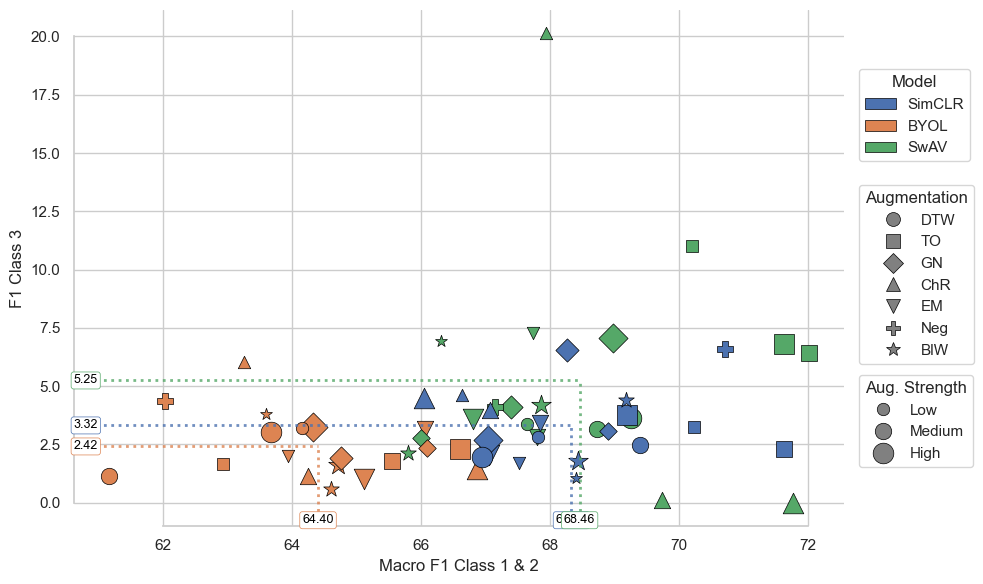

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Compute macro avg PR AUC for classes 1 & 2
# ft_res_df['test_pr_auc_class12'] = (ft_res_df.test_pr_auc_class1 + ft_res_df.test_pr_auc_class2) / 2

le_res_df['val_f1_class12'] = (le_res_df.val_f1_class1  + le_res_df.val_f1_class2) /2
# print(num_class1, num_class2)

# Plot style
sns.set(style='whitegrid')

# Set color and marker dictionaries
model_palette = sns.color_palette('deep', n_colors=le_res_df['model'].nunique())
model_colors = dict(zip(le_res_df['model'].unique(), model_palette))

augmentations = le_res_df['augmentation'].unique()
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
marker_dict = dict(zip(augmentations, markers))

# Map size values first (e.g., using your size_map)
size_map = {1: 80, 2: 140, 3: 220}
le_res_df['plot_size'] = le_res_df['aug_strength'].map(size_map)

# Sort so large points are plotted first
plot_df = le_res_df.sort_values('plot_size', ascending=False)

# Plot
# x_col = 'test_pr_auc_class12'
# y_col = 'test_pr_auc_class3'
x_col = 'val_f1_class12'
y_col = 'val_f1_class3'

fig, ax = plt.subplots(figsize=(10, 6))  # Create figure and axis

for _, row in plot_df.iterrows():
    ax.scatter(
        row[x_col],
        row[y_col],
        color=model_colors[row['model']],
        marker=marker_dict[row['augmentation']],
        edgecolor='black',
        s=row['plot_size'],
        linewidth=0.5
    )

# Legend for models (colors)
model_display_names = {
    'simclr': 'SimCLR',
    'byol': 'BYOL',
    'swav': 'SwAV'
}

model_handles = [
    mpatches.Patch(facecolor=color, label=model_display_names.get(model, model), edgecolor='black', linewidth=0.5)
    for model, color in model_colors.items()
]

# Legend for augmentation strength (point size)
strength_labels = {1: 'Low', 2: 'Medium', 3: 'High'}
strength_handles = [
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                  markersize=(size_map[strength] ** 0.5),  # matplotlib scales s as area
                  label=label,
                  markeredgecolor='black', markeredgewidth=0.5)
    for strength, label in strength_labels.items()
]

# Place third legend
third_legend = plt.legend(handles=strength_handles, title='Aug. Strength', loc='lower left', bbox_to_anchor=(1.01, 0.1))
plt.gca().add_artist(third_legend)

# Legend for augmentations (markers)
augmentation_handles = [
    mlines.Line2D([], [], color='gray', marker=marker_dict[aug], linestyle='None',
                  markersize=10, label=aug, 
                  markeredgecolor='black', markeredgewidth=0.5)
    for aug in augmentations
]

# Place legends
first_legend = plt.legend(handles=model_handles, title='Model', loc='upper left', bbox_to_anchor=(1.01, 0.9))
second_legend = plt.legend(handles=augmentation_handles, title='Augmentation', loc='lower left', bbox_to_anchor=(1.01, 0.3))
plt.gca().add_artist(first_legend)  # Ensure both legends are shown

x_limits = ax.get_xlim()
y_limits = ax.get_ylim()
print(x_limits, y_limits)
# Draw dotted lines and annotate mean values for each model
for model in le_res_df['model'].unique():
    model_data = le_res_df[le_res_df['model'] == model]
    x_mean = model_data[x_col].mean()
    y_mean = model_data[y_col].mean()
    color = model_colors[model]

    
    # Vertical dotted line from bottom to the intersection point
    ax.plot([x_mean, x_mean], [y_limits[0], y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)

    # Horizontal dotted line from left to the intersection point
    ax.plot([x_limits[0], x_mean], [y_mean, y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)


    # Annotate at axis intersections with background
    ax.text(
        x_mean, y_limits[0], f'{x_mean:.2f}', color='black',
        fontsize=9, ha='center', va='bottom',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )

    ax.text(
        x_limits[0], y_mean, f'{y_mean:.2f}', color='black',
        fontsize=9, ha='left', va='center',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )

ax.set_xlim(x_limits)
ax.set_ylim(y_limits)



# Axis labels and title
plt.xlabel(f'Macro F1 Class 1 & 2', fontsize=12)
plt.ylabel(f'F1 Class 3', fontsize=12) # Macro F1 class 3
# plt.title(f'Linear Evaluation: F1-Score for Class 3 vs Class 1 & 2', fontsize=14)

# Final adjustments
sns.despine(trim=True)
plt.tight_layout()
plt.savefig(f"../images/augmentations/linear_f1_class3_vs_rest_val.pdf", dpi=300)
plt.show()


#### Val - FT


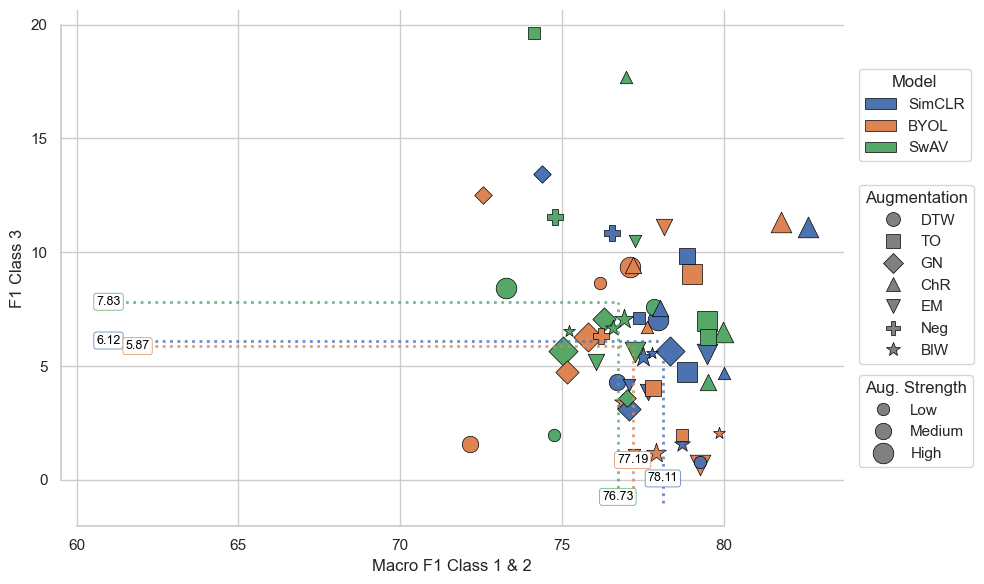

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np

# Assume num_class1 and num_class2 already computed macro is just non weighted average
ft_res_df['val_f1_class12'] = (ft_res_df.val_f1_class1+ ft_res_df.val_f1_class2) /2

# Style
sns.set(style='whitegrid')

# Color and marker settings
model_palette = sns.color_palette('deep', n_colors=ft_res_df['model'].nunique())
model_colors = dict(zip(ft_res_df['model'].unique(), model_palette))

augmentations = ft_res_df['augmentation'].unique()
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']
marker_dict = dict(zip(augmentations, markers))

# Size
size_map = {1: 80, 2: 140, 3: 220}
ft_res_df['plot_size'] = ft_res_df['aug_strength'].map(size_map)

ft_plot_df = ft_res_df.sort_values('plot_size', ascending=False)

x_col = 'val_f1_class12'
y_col = 'val_f1_class3'

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
for _, row in ft_plot_df.iterrows():
    ax.scatter(
        row[x_col],
        row[y_col],
        color=model_colors[row['model']],
        marker=marker_dict[row['augmentation']],
        edgecolor='black',
        s=row['plot_size'],
        linewidth=0.5,
        alpha=1
    )

# Match linear plot axis ranges
# Match linear plot axis ranges
# ax.set_xlim(x_limits + np.array([0, 3]))
# ax.set_ylim(y_limits + np.array([0, 3]))

# Legend for models (colors)
model_display_names = {
    'simclr': 'SimCLR',
    'byol': 'BYOL',
    'swav': 'SwAV'
}

model_handles = [
    mpatches.Patch(facecolor=color, label=model_display_names.get(model, model), edgecolor='black', linewidth=0.5)
    for model, color in model_colors.items()
]

# Legend for augmentation strength (point size)
strength_labels = {1: 'Low', 2: 'Medium', 3: 'High'}
strength_handles = [
    mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                  markersize=(size_map[strength] ** 0.5),  # matplotlib scales s as area
                  label=label,
                  markeredgecolor='black', markeredgewidth=0.5)
    for strength, label in strength_labels.items()
]

# Place third legend
third_legend = plt.legend(handles=strength_handles, title='Aug. Strength', loc='lower left', bbox_to_anchor=(1.01, 0.1))
plt.gca().add_artist(third_legend)

# Legend for augmentations (markers)
augmentation_handles = [
    mlines.Line2D([], [], color='gray', marker=marker_dict[aug], linestyle='None',
                  markersize=10, label=aug, 
                  markeredgecolor='black', markeredgewidth=0.5)
    for aug in augmentations
]

# Place legends
first_legend = plt.legend(handles=model_handles, title='Model', loc='upper left', bbox_to_anchor=(1.01, 0.9))
second_legend = plt.legend(handles=augmentation_handles, title='Augmentation', loc='lower left', bbox_to_anchor=(1.01, 0.3))
plt.gca().add_artist(first_legend)  # Ensure both legends are shown

# draw mean lines
for i, model in enumerate(['swav', 'simclr', 'byol']):
    model_data = ft_plot_df[ft_plot_df['model'] == model]
    x_mean = model_data[x_col].mean()
    y_mean = model_data[y_col].mean()
    color = model_colors[model]

    
    # Vertical dotted line from bottom to the intersection point
    ax.plot([x_mean, x_mean], [y_limits[0], y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)

    # Horizontal dotted line from left to the intersection point
    ax.plot([x_limits[0], x_mean], [y_mean, y_mean], linestyle=':', color=color, linewidth=2, alpha=0.8)


    # Annotate at axis intersections with background
    ax.text(
        x_mean, y_limits[0]+(y_limits[0] + y_limits[1])*i*0.04, f'{x_mean:.2f}', color='black',
        fontsize=9, ha='center', va='bottom',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )

    ax.text(
        x_limits[0] if i != 2 else x_limits[0] + 0.9, 
        y_mean, f'{y_mean:.2f}', 
        color='black',
        fontsize=9, ha='left', va='center',
        bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2', linewidth=0.5)
    )


# Labels and formatting
ax.set_xlabel('Macro F1 Class 1 & 2', fontsize=12)
ax.set_ylabel('F1 Class 3', fontsize=12)
# ax.set_title('Fine-tuned: Macro F1 vs Class 3 F1', fontsize=14)

sns.despine(trim=True)
plt.tight_layout()
plt.savefig(f"../images/augmentations/finetuned_f1_class3_vs_rest_val_2.pdf", dpi=300)
plt.show()


F1 plot Linear, shit at class 1 & 2? No the axis is different

### Continue

### Average Performance Overview

In [ ]:
finetune_df[['model', 'val_macro_f1', 'test_macro_f1', 'val_acc_class3', 'test_acc_class3']].groupby('model').mean()

,val_macro_f1,test_macro_f1,val_acc_class3,test_acc_class3
model,,,,
byol,0.545130,0.785155,0.037085,0.564741
simclr,0.554911,0.779893,0.032926,0.539916
swav,0.551259,0.745607,0.056721,0.471076


In [ ]:
linear_eval_df[['model', 'val_macro_f1', 'test_macro_f1', 'val_acc_class3', 'test_acc_class3']].groupby('model').mean()

,val_macro_f1,test_macro_f1,val_acc_class3,test_acc_class3
model,,,,
byol,0.458114,0.729969,0.014171,0.586167
simclr,0.496400,0.748429,0.017450,0.497764
swav,0.495992,0.726443,0.037614,0.461807


If model is performing good on validation, it performs worse on the test data... as can be seen for 'swav' and reversely for 'byol' and 'simclr'.

This trend could be confirmed by looking at the individual augmentation runs.

Average F1-Score Across Augmentations Per Model


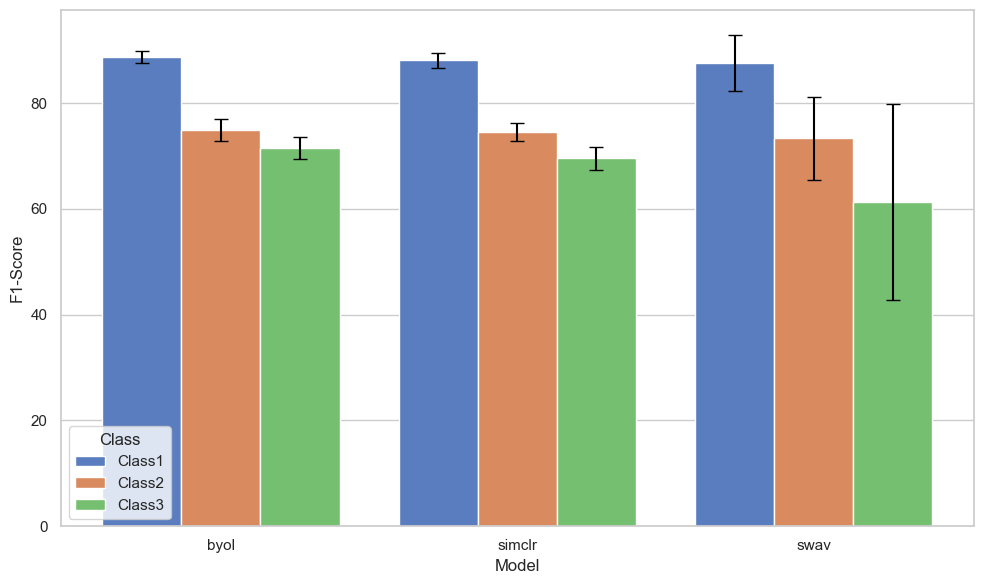

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate mean and standard deviation for each model and metric
metrics = ['test_f1_class1', 'test_f1_class2', 'test_f1_class3']
summary_df = ft_res_df.groupby('model')[metrics].agg(['mean', 'std']).reset_index()

# Flatten MultiIndex columns
summary_df.columns = ['model'] + ['_'.join(col).strip() for col in summary_df.columns.values[1:]]

# Prepare data for plotting
plot_data = []
for _, row in summary_df.iterrows():
    for metric in metrics:
        plot_data.append({
            'Model': row['model'],
            'F1-Score': metric.split('_')[-1].capitalize(),  # F1, Prec, Rc
            'Mean': row[f'{metric}_mean'],
            'Std': row[f'{metric}_std']
        })

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=plot_df,
    x='Model',
    y='Mean',
    hue='F1-Score',
    errorbar=None,
    palette='muted'
)

# add error bars
for bar, (_, row) in zip(ax.patches, plot_df.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    std = row['Std']
    ax.errorbar(
        x=x,
        y=y,
        yerr=std,
        fmt='none',
        c='black',
        capsize=5
    )

print('Average F1-Score Across Augmentations Per Model')
plt.ylabel('F1-Score')
plt.xlabel('Model')
plt.legend(title='Class')
plt.tight_layout()
plt.show()


Interpretation:
Uncertainty of swav is a good sign since it indicates sensitivity to the used augmentations.
Also note that the maximum performance f1 is achieved by swav for each class but not using the same augmentation. 

### Representation comparison val vs test
Implement with model and augmentation as parameter? ---> requires to run an pretraining 150 epochs since I require the representations, or load from pre-trained model???

Is the disparity between val and test consitent accross all combinations?

Problem occurs through variation in ```class 3```  distributions

In [ ]:
# Calculate the difference between test_acc_class3 and val_acc_class3
linear_eval_df['diff_acc_class3'] = linear_eval_df['test_acc_class3'] - linear_eval_df['val_acc_class3']

# Compute the average difference per model
average_diff_per_model = linear_eval_df.groupby('model')['diff_acc_class3'].mean()

# Display the result
average_diff_per_model


model
byol      0.571995
simclr    0.480314
swav      0.424193
Name: diff_acc_class3, dtype: float64

This shows that the SwAV representations from the pre-training are performing better on the test data class 3, since the difference is the smallest.  

# Results plots

#### Representation comparison
Do it for all 3 models and choose the best augmentation for each?

In [ ]:
# pretrained model paths
import pandas as pd
pretrained_models = pd.read_csv('finished_models/pretrained_paths.csv').sort_values('augmentation')
print(pretrained_models.augmentation.unique())
pretrained_models.head()

['BlW_fs=100_C=0.1' 'BlW_fs=100_C=0.7' 'BlW_fs=100_C=1.0'
 'ChR_magnitude_range=[0.33, 1.0]' 'ChR_magnitude_range=[0.33, 3.0]'
 'ChR_magnitude_range=[0.5, 2.0]' 'DTW_w=1_r=10' 'DTW_w=3_r=10'
 'DTW_w=3_r=5' 'EM_var=0.01' 'EM_var=0.5' 'EM_var=1.0' 'GN_var=0.01'
 'GN_var=0.1' 'GN_var=1.0' 'Neg_True' 'TO_crop_ratio_range=[0.0, 0.5]'
 'TO_crop_ratio_range=[0.1, 0.2]' 'TO_crop_ratio_range=[0.4, 0.5]']


,model,augmentation,relative_checkpoint_path
54,swav,BlW_fs=100_C=0.1,finished_models/pretrained_models_swav/08-04-2...
35,simclr,BlW_fs=100_C=0.1,finished_models/pretrained_models_simclr/26-04...
16,byol,BlW_fs=100_C=0.1,finished_models/pretrained_models_byol/17-04-2...
36,simclr,BlW_fs=100_C=0.7,finished_models/pretrained_models_simclr/26-04...
55,swav,BlW_fs=100_C=0.7,finished_models/pretrained_models_swav/09-04-2...


In [ ]:
from eval import load_model, get_dataset, set_seed
import yaml
from pathlib import Path

set_seed(42)
# To get representations for both the val and test set, they need to be evaluated with the loaded checkpoint
method = 'swav'  # or 'byol', 'swav' 
augmentation = 'TO_crop_ratio_range=[0.4, 0.5]'
selected_class = '2'

location = pretrained_models.loc[
	(pretrained_models['model'] == method) & (pretrained_models['augmentation'] == augmentation),
	'relative_checkpoint_path'
].values[0]

# load pretrained model as in eval.py
model = load_model(
    num_classes=3, use_pretrained=True, hidden=False,
    location=location, method=method
)

Setting seed to 42
load pre-trained model from finished_models/pretrained_models_swav/07-04-2025-23-25_swav_TO_crop_ratio_range=[0.4, 0.5]/checkpoints/best_pretrained_swav_TO_crop_ratio_range=[0.4, 0.5]_epoch=35-val_loss=4.1573.ckpt


In [ ]:
# load the data as in eval.py
# load config from checkpoint folder or fall back to default config
run_folder = Path(location).parent.parent

config_path = run_folder / "config.txt"
if config_path.is_file():
    config_file = config_path
else:
    config_file = "bolts_config.yaml"

with open(config_file, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
# get settings from config file
num_workers = config["dataset"]["num_workers"]
batch_size = config["batch_size"]
data_path = config["dataset"]["data_path"]
signal_fs = config["dataset"]["signal_fs"]
train_records = config["dataset"]["train_records"]
validation_records = config["dataset"]["val_records"]
test_records = config["dataset"]["test_records"]
normalize = False

_, train_loader, valid_loader = get_dataset(batch_size, num_workers, data_path, signal_fs=signal_fs, 
                                            train_records=train_records, validation_records=validation_records, test_records=test_records,
                                            test=False, normalize=normalize, mode='linear_evaluation')
_, _, test_loader = get_dataset(batch_size, num_workers, data_path, signal_fs=signal_fs, 
                                            train_records=train_records, validation_records=validation_records, test_records=test_records,
                                            test=True, normalize=normalize, mode='linear_evaluation')

In [ ]:
from collections import Counter
# only use annotated subset of train data since i will compare class 3 
print('train class dist', Counter([item[1].argmax().item() for item in train_loader.dataset]))
print('valid class dist', Counter([item[1].argmax().item() for item in valid_loader.dataset]))
print('test class dist', Counter([item[1].argmax().item() for item in test_loader.dataset]))

train class dist Counter({0: 27405, 2: 18939, 1: 14090})
valid class dist Counter({1: 19606, 0: 18661, 2: 1493})
test class dist Counter({0: 26000, 1: 12250, 2: 1130})


In [ ]:
import torch
from tqdm import tqdm

def get_representations(loader, model, sel_class='2'):
    model.eval()
    representations = []
    selected_indices = []
    global_index = 0
    with torch.no_grad():
        for signals, labels in tqdm(loader):
            batch_size = signals.size(0)
            class_indices = torch.argmax(labels, dim=1)

            if sel_class != 'all':
                mask = class_indices == int(sel_class)
                signals = signals[mask]
                labels = labels[mask]
                local_indices = torch.arange(batch_size)[mask] + global_index
            else:
                local_indices = torch.arange(batch_size) + global_index
            signals = signals.to(next(model.parameters()).device)
            features = model.features(signals)
            representations.append(features.cpu())
            selected_indices.extend(local_indices.tolist())
            global_index += batch_size
    return torch.cat(representations, dim=0), selected_indices


# Generate representations
train_representations, train_indices = get_representations(train_loader, model, sel_class=selected_class)
val_representations, val_indices  = get_representations(valid_loader, model, sel_class=selected_class)
test_representations, test_indices = get_representations(test_loader, model, sel_class=selected_class)

# get all other representations
other_classes = list(set(range(3)) - {int(selected_class)})
other_representations = []  # Initialize a list to store other class representations
# for other_class in other_classes:
#     # other_repr_train = get_representations(train_loader, model, sel_class=other_class)
#     other_repr_val = get_representations(valid_loader, model, sel_class=other_class)
#     other_repr_test = get_representations(test_loader, model, sel_class=other_class)
#     # Append the representations for the current class
#     other_representations.append(other_repr_val)
#     other_representations.append(other_repr_test)
    
# include train selected class
other_representations.append(train_representations)
# Concatenate all other class representations into a single tensor
other_representations = torch.cat(other_representations, dim=0)



print("Validation representations shape:", val_representations.shape)
print("Test representations shape:", test_representations.shape)
print("All other representations shape:", other_representations.shape)


100%|██████████| 39/39 [00:37<00:00,  1.04it/s]

Validation representations shape: torch.Size([1493, 512, 1])
Test representations shape: torch.Size([1130, 512, 1])
All other representations shape: torch.Size([18935, 512, 1])


In [ ]:
def get_correct_mask(selected_class, method, augmentation, indices, correct_dict, df, mode='linear', data_split='test'):
    selected_class = int(selected_class)
    correct = correct_dict[mode][f"{method}_{augmentation}"][data_split][0][indices]
    predictions = correct_dict[mode][f"{method}_{augmentation}"][data_split][1]
    acc_dict = correct.sum() / len(correct)
    df_aug = augmentation.split('_')[0]
    df_params = '_'.join(augmentation.split('_')[1:])
    row = df[(df['model'] == method) & (df['augmentation'] == df_aug) & (df['parameters'] == df_params)]
    acc_df = row[f'{data_split}_acc_class{selected_class + 1}'].values[0] if not row.empty else 0.0
    assert acc_dict == acc_df
    # print(mode)
    # print(f"[Correct Dict] Accuracy class {selected_class+1}: {acc_dict:.4f}")
    # print(f"[Eval DataFrame] Accuracy class {selected_class+1}: {acc_df:.4f}")
    return correct, predictions

# compare accuracy from the dict with the accuracy in the dataframe 
# after using the extracted val and test indices from the dataloders used for the representation extraction
le_correct_mask_val, le_val_preds = get_correct_mask(selected_class, method, augmentation, val_indices, correct_dict, linear_eval_df, mode='linear', data_split='val')
ft_correct_mask_val, ft_val_preds = get_correct_mask(selected_class, method, augmentation, val_indices, correct_dict, finetune_df, mode='finetuned', data_split='val')

le_correct_mask_test, le_test_preds = get_correct_mask(selected_class, method, augmentation, test_indices, correct_dict, linear_eval_df, mode='linear', data_split='test')
ft_correct_mask_test, ft_test_preds = get_correct_mask(selected_class, method, augmentation, test_indices, correct_dict, finetune_df, mode='finetuned', data_split='test')

print(le_correct_mask_val.shape)
print(ft_correct_mask_val.shape)
print(le_correct_mask_test.shape)
print(ft_correct_mask_test.shape)

(1493,)
(1493,)
(1130,)
(1130,)


In [ ]:
# is the incorrect prediction for the large cluster in UMAP, global index 19659
le_val_preds[15621]

1

In [ ]:
# reduce number of representations
reduce = False
if reduce == True:
    other_representations = other_representations[:100]
    val_representations = val_representations[:100]
    test_representations = test_representations[:100]
print(other_representations.shape)
print(val_representations.shape)
print(test_representations.shape)

torch.Size([18935, 512, 1])
torch.Size([1493, 512, 1])
torch.Size([1130, 512, 1])


In [ ]:
from scipy.stats import gaussian_kde
import numpy as np

def compute_kde_overlap(umap_embeddings, all_labels, label_a, label_b, df, grid_size=100):
    # Extract UMAP points
    points_a = umap_embeddings[all_labels == label_a].T
    points_b = umap_embeddings[all_labels == label_b].T

    # Compute KDEs
    kde_a = gaussian_kde(points_a)
    kde_b = gaussian_kde(points_b)

    # Define shared grid over the UMAP space
    xmin, xmax = df["UMAP1"].min(), df["UMAP1"].max()
    ymin, ymax = df["UMAP2"].min(), df["UMAP2"].max()
    xx, yy = np.mgrid[xmin:xmax:complex(grid_size), ymin:ymax:complex(grid_size)]
    grid_coords = np.vstack([xx.ravel(), yy.ravel()])

    # Evaluate KDEs on the grid
    density_a = kde_a(grid_coords)
    density_b = kde_b(grid_coords)

    # Compute overlap
    overlap_integral = np.sum(np.minimum(density_a, density_b))
    overlap_normalized = overlap_integral / np.sum(density_a)

    return overlap_normalized

In [ ]:
# import torch
# import numpy as np
# import umap
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Combine representations
# all_representations = torch.cat([val_representations, test_representations], dim=0).squeeze().cpu().numpy()

# # Apply UMAP
# umap_2d = umap.UMAP(n_components=2, random_state=42)
# umap_embeddings = umap_2d.fit_transform(all_representations)

# # Labels
# val_labels = np.zeros(len(val_representations))  # 0 for validation
# test_labels = np.ones(len(test_representations))  # 1 for test
# all_labels = np.concatenate([val_labels, test_labels])

# # Prepare data for seaborn
# df = pd.DataFrame({
#     "UMAP1": umap_embeddings[:, 0],
#     "UMAP2": umap_embeddings[:, 1],
#     "Label": all_labels
# })

# # Compute the overlap
# overlap_value = compute_kde_overlap_from_embeddings(
#     umap_embeddings=umap_embeddings,
#     all_labels=all_labels,
#     df=df
# )

# # Label mapping
# label_names = {0: "Validation", 1: "Test"}
# df["Label"] = df["Label"].map(label_names)

# # Seaborn style
# sns.set(style="whitegrid", font_scale=1.3)
# palette = {"Validation": "mediumpurple", "Test": "green"}

# # Create JointGrid
# g = sns.JointGrid(data=df, x="UMAP1", y="UMAP2", hue="Label", height=8)

# # KDE marginals
# g.plot_marginals(sns.kdeplot, common_norm=False, fill=True, alpha=0.4, palette=palette)

# # clean the axis with helper function
# def clean_axis(ax, show_spines=['left', 'bottom'], spine_color='black'):
#     for spine_name, spine in ax.spines.items():
#         spine.set_visible(spine_name in show_spines)
#         spine.set_color(spine_color)
#     ax.grid(False)
# clean_axis(g.ax_marg_x)
# clean_axis(g.ax_marg_y)
# clean_axis(g.ax_joint)

# # configure ticks on the kde plots
# def configure_ticks(ax, labelbottom=False, labelleft=True):
#     ax.tick_params(
#         axis='both',
#         which='major',
#         direction='out',
#         length=4,
#         width=1,
#         bottom=True,
#         top=False,
#         left=True,
#         right=False,
#         labelbottom=labelbottom,
#         labelleft=labelleft
#     )

# # apply to marginals kde plots
# configure_ticks(g.ax_marg_x, labelbottom=False, labelleft=True)
# configure_ticks(g.ax_marg_y, labelbottom=True, labelleft=False)

# # Main scatter plot
# g.plot_joint(
#     sns.scatterplot,
#     s=40,
#     alpha=0.6,
#     edgecolor='white',
#     linewidth=0.5,
#     palette=palette,
#     rasterized=True,
# )

# # Custom legend
# handles, labels = g.ax_joint.get_legend_handles_labels()
# g.ax_joint.legend(handles=handles, labels=labels, title="Data Split", loc='upper right', frameon=True)

# # Remove duplicate legends from marginals
# if g.ax_marg_x.get_legend() is not None:
#     g.ax_marg_x.get_legend().remove()

# # Remove axis labels but keep ticks
# g.ax_joint.set_xlabel("")
# g.ax_joint.set_ylabel("")
# g.ax_marg_x.set_xlabel("")
# g.ax_marg_y.set_ylabel("")

# plt.tight_layout()
# plt.savefig(f"../images/UMAP/umap_representations_{method}_{augmentation}_class{int(selected_class)+1}_overlap={overlap_value:.2f}.pdf", dpi=300)
# plt.show()


Evaluation-Time Representation Space


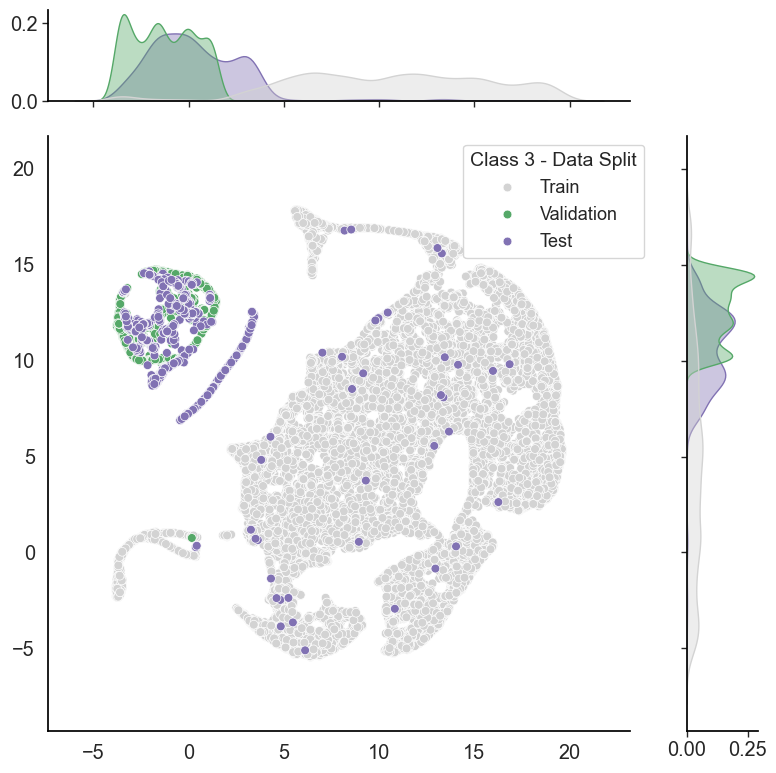

In [ ]:
# with train also:
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine representations
all_representations = torch.cat([other_representations, val_representations, test_representations], dim=0).squeeze().cpu().numpy()

# Apply UMAP
umap_2d = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_2d.fit_transform(all_representations)

# anchor class 3 train to right side
if np.mean(umap_embeddings[:len(other_representations), 0]) < 0:
    umap_embeddings[:, 0] *= -1  # flip x-axis
    umap_embeddings[:, 1] *= -1  # flip y-axis
    
# Labels
other_labels = np.zeros(len(other_representations))       # 0 for train
val_labels = np.ones(len(val_representations))            # 1 for validation
test_labels = np.repeat(2, len(test_representations))     # 2 for test
all_labels = np.concatenate([other_labels, val_labels, test_labels])

# Prepare data for seaborn
df = pd.DataFrame({
    "UMAP1": umap_embeddings[:, 0],
    "UMAP2": umap_embeddings[:, 1],
    "Label": all_labels
})

overlap_val = compute_kde_overlap(
    umap_embeddings=umap_embeddings,
    all_labels=all_labels,
    label_a=0,  # Train
    label_b=1,  # Val
    df=df
)

overlap_test = compute_kde_overlap(
    umap_embeddings=umap_embeddings,
    all_labels=all_labels,
    label_a=0,  # Train
    label_b=2,  # Test
    df=df
)

# Label mapping
label_names = {0: "Train", 1: "Validation", 2: "Test"}
# df = df.sort_values(by='Label', ascending=True)
df["Label"] = df["Label"].map(label_names)

# Seaborn style
sns.set(style="whitegrid", font_scale=1.3)

# color palette
# palette = {"Train": "lightgray", "Val.": "#BE2A52", "Test": "#2A52BE"}
# #DB9370
# complement
# mediumpurple green

# Get a 'deep' color palette with at least 3 colors
color_palette = sns.color_palette('deep', 5)

# Assign to your labels
palette = {
    "Train": 'lightgray',
    "Validation": color_palette[2],
    "Test": color_palette[4]
}

# Create JointGrid
g = sns.JointGrid(data=df, x="UMAP1", y="UMAP2", hue="Label", height=8)

# KDE marginals
g.plot_marginals(sns.kdeplot, common_norm=False, fill=True, alpha=0.4, palette=palette)

# clean the axis with helper function
def clean_axis(ax, show_spines=['left', 'bottom'], spine_color='black'):
    for spine_name, spine in ax.spines.items():
        spine.set_visible(spine_name in show_spines)
        spine.set_color(spine_color)
    ax.grid(False)
clean_axis(g.ax_marg_x)
clean_axis(g.ax_marg_y)
clean_axis(g.ax_joint)

# configure ticks on the kde plots
def configure_ticks(ax, labelbottom=False, labelleft=True):
    ax.tick_params(
        axis='both',
        which='major',
        direction='out',
        length=4,
        width=1,
        bottom=True,
        top=False,
        left=True,
        right=False,
        labelbottom=labelbottom,
        labelleft=labelleft
    )

# apply to marginals kde plots
configure_ticks(g.ax_marg_x, labelbottom=False, labelleft=True)
configure_ticks(g.ax_marg_y, labelbottom=True, labelleft=False)

# Main scatter plot
g.plot_joint(
    sns.scatterplot,
    s=40,
    alpha=1,
    edgecolor='white',
    linewidth=0.5,
    palette=palette,
    rasterized=True,
)

# Filter out "Other" from the legend
handles, labels = g.ax_joint.get_legend_handles_labels()
filtered = [(h, l) for h, l in zip(handles, labels) if l != "Other"]
if filtered:
    handles, labels = zip(*filtered)
    g.ax_joint.legend(handles=handles, labels=labels, title="Class 3 - Data Split", 
                      frameon=True, loc='upper right', bbox_to_anchor=(1.04, 1), title_fontsize=14, fontsize=13)

# Remove duplicate legends from marginals
if g.ax_marg_x.get_legend() is not None:
    g.ax_marg_x.get_legend().remove()

# Remove axis labels but keep ticks
g.ax_joint.set_xlabel("")
g.ax_joint.set_ylabel("")
g.ax_marg_x.set_xlabel("")
g.ax_marg_y.set_ylabel("")

print('Evaluation-Time Representation Space')
plt.tight_layout()
plt.savefig(f"../images/UMAP/umap_representations_{method}_{augmentation}_class{int(selected_class)+1}_overlap=({overlap_val:.3f},{overlap_test:.3f}).pdf", dpi=300)
plt.show()


BOTH
Total evaluated items: 2623
  Correct predictions: 623
  Incorrect predictions: 2000
Evaluation-Time Correctness Overlay – Split: BOTH


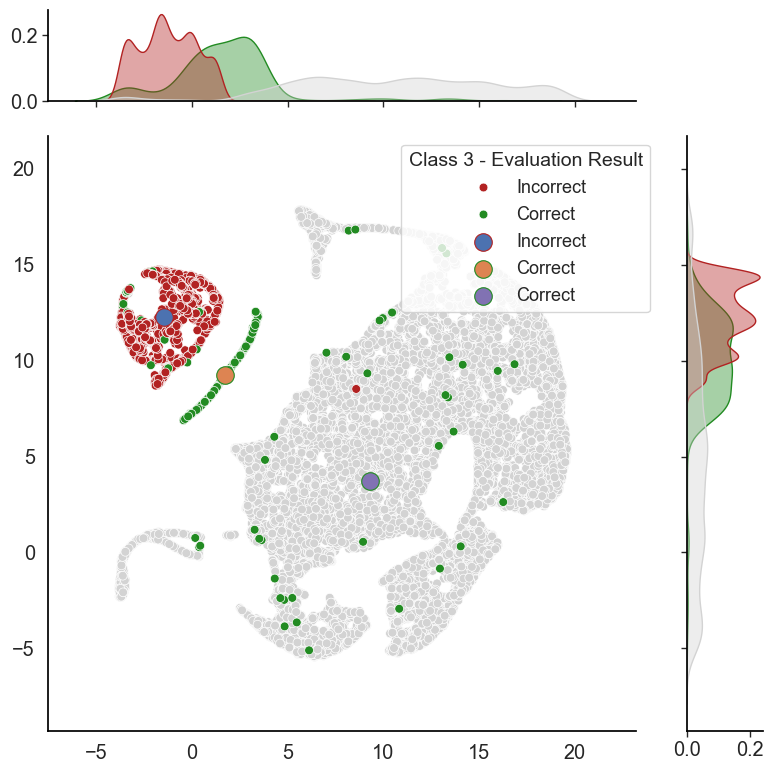

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Toggle: 'val', 'test', or 'both'
split = "both"

# Optional: IDs to highlight
highlight_ids = [19659, 21046, 20803]
highlight_colors = sns.color_palette("deep")
highlight_styles = [highlight_colors[0], highlight_colors[1], highlight_colors[4]]

# Set lengths for indexing
n_train = len(other_representations)
n_val = len(val_representations)
n_test = len(test_representations)

# Construct correctness array
correctness = np.full(len(df), np.nan)
correctness[df["Label"] == "Validation"] = le_correct_mask_val
correctness[df["Label"] == "Test"] = le_correct_mask_test
df["Correct"] = correctness

# Copy the original DataFrame and assign correctness
df_sub = df.copy()
df_sub["Correct"] = correctness

# Apply masking based on split
if split == "val":
    df_sub.loc[n_train + n_val:, "Correct"] = np.nan
elif split == "test":
    df_sub.loc[n_train:n_train + n_val, "Correct"] = np.nan

# Count stats
eval_mask = df_sub["Correct"].notna()
total_eval_items = eval_mask.sum()
num_correct = df_sub.loc[eval_mask, "Correct"].sum()
num_incorrect = total_eval_items - num_correct
print(split.upper())
print(f"Total evaluated items: {total_eval_items}")
print(f"  Correct predictions: {int(num_correct)}")
print(f"  Incorrect predictions: {int(num_incorrect)}")

# Prepare plot labels
df_sub["CorrectLabel"] = df_sub["Correct"].map({True: "Correct", False: "Incorrect", np.nan: "Train"})
df_sub["CorrectLabel"] = pd.Categorical(df_sub["CorrectLabel"], categories=["Train", "Incorrect", "Correct"], ordered=True)

# Seaborn style and palette
sns.set(style="whitegrid", font_scale=1.3)
palette = {
    "Train": "lightgray",
    "Correct": "forestgreen",
    "Incorrect": "firebrick"
}

# Create JointGrid
g = sns.JointGrid(data=df_sub, x="UMAP1", y="UMAP2", hue="CorrectLabel", height=8)

# KDE marginals
g.plot_marginals(
    sns.kdeplot,
    common_norm=False,
    fill=True,
    alpha=0.4,
    palette=palette
)

# Axis cleanup
def clean_axis(ax, show_spines=['left', 'bottom'], spine_color='black'):
    for spine_name, spine in ax.spines.items():
        spine.set_visible(spine_name in show_spines)
        spine.set_color(spine_color)
    ax.grid(False)

clean_axis(g.ax_marg_x)
clean_axis(g.ax_marg_y)
clean_axis(g.ax_joint)

# Tick configuration
def configure_ticks(ax, labelbottom=False, labelleft=True):
    ax.tick_params(
        axis='both',
        which='major',
        direction='out',
        length=4,
        width=1,
        bottom=True,
        top=False,
        left=True,
        right=False,
        labelbottom=labelbottom,
        labelleft=labelleft
    )

configure_ticks(g.ax_marg_x, labelbottom=False, labelleft=True)
configure_ticks(g.ax_marg_y, labelbottom=True, labelleft=False)

# Main scatter plot
g.plot_joint(
    sns.scatterplot,
    s=40,
    alpha=1,
    edgecolor='white',
    linewidth=0.5,
    palette=palette,
    rasterized=True
)

# Highlight multiple IDs if provided
if highlight_ids:
    for i, hid in enumerate(highlight_ids):
        if hid in df_sub.index:
            x_hl = df_sub.loc[hid, "UMAP1"]
            y_hl = df_sub.loc[hid, "UMAP2"]
            color = highlight_styles[i % len(highlight_styles)]
            status = df_sub.loc[hid, "CorrectLabel"]
            g.ax_joint.scatter(
                x_hl, y_hl,
                s=160,
                facecolor=color,
                edgecolor='forestgreen' if status == "Correct" else 'firebrick',
                linewidth=0.8,
                label=f"{status}",
                zorder=5
            )

# Custom legend
handles, labels = g.ax_joint.get_legend_handles_labels()
filtered = [(h, l) for h, l in zip(handles, labels) if l != "Train"]
if filtered:
    handles, labels = zip(*filtered)
    g.ax_joint.legend(
        handles=handles,
        labels=labels,
        title="Class 3 - Evaluation Result",
        frameon=True,
        loc='upper right',
        bbox_to_anchor=(1.04, 1),
        title_fontsize=14, 
        fontsize=13
    )

# Remove duplicate legends
if g.ax_marg_x.get_legend() is not None:
    g.ax_marg_x.get_legend().remove()

# Final plot adjustments
g.ax_joint.set_xlabel("")
g.ax_joint.set_ylabel("")
g.ax_marg_x.set_xlabel("")
g.ax_marg_y.set_ylabel("")

# Filename construction
filename = f"../images/UMAP/umap_correctness_{method}_{augmentation}_class{int(selected_class)+1}_split={split}"
if highlight_ids:
    filename += "_hl=" + "-".join(map(str, highlight_ids))
filename += ".pdf"

print(f"Evaluation-Time Correctness Overlay – Split: {split.upper()}")
plt.tight_layout()
plt.savefig(filename, dpi=300)
plt.show()


### Signal analysis of errors

In [ ]:
# Compute average y-range for class 1 (adjust based on your dataset structure)
class1_signals = []

for dataset, indices in [(train_loader, train_indices), (valid_loader, val_indices), (test_loader, test_indices)]:
    for i in indices:
        signal, label = dataset.dataset[i]
        if label.argmax().item() == 0:  # Class 1 (index 0)
            class1_signals.append(signal.squeeze().numpy())

class1_signals = np.array(class1_signals)
avg_min = np.mean([s.min() for s in class1_signals])
avg_max = np.mean([s.max() for s in class1_signals])


In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Assume df_sub, loaders, and constants are defined
df_dash = df_sub.copy()

df_dash["DatasetIndex"] = df_dash.index
df_dash["HoverLabel"] = (
    "Idx: " + df_dash["DatasetIndex"].astype(str) +
    "<br>Split: " + df_dash["Label"].astype(str) +
    "<br>Status: " + df_dash["CorrectLabel"].astype(str)
)

fig = px.scatter(
    df_dash,
    x="UMAP1",
    y="UMAP2",
    color="CorrectLabel",
    color_discrete_map={"Train": "lightgray", "Correct": "forestgreen", "Incorrect": "firebrick"},
    hover_name="HoverLabel",
    custom_data=["DatasetIndex"],
    height=700,
)
fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color='black')))

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H3("Interactive UMAP with Signal Viewer"),
    dcc.Graph(id='umap-plot', figure=fig),

    html.Div([
        html.Label("Manual signal selection:"),
        dcc.Dropdown(
            id='dataset-dropdown',
            options=[
                {"label": "Train", "value": "Train"},
                {"label": "Validation", "value": "Validation"},
                {"label": "Test", "value": "Test"}
            ],
            placeholder="Select dataset",
            style={"width": "200px"}
        ),
        dcc.Input(id='manual-index', type='number', placeholder='Enter local index', debounce=True)
    ], style={"marginTop": "10px", "marginBottom": "10px"}),

    html.Div(id='signal-title', style={"fontWeight": "bold"}),
    dcc.Graph(id='signal-plot', style={"height": "300px"})
])

@app.callback(
    [Output('signal-plot', 'figure'),
     Output('signal-title', 'children'),
     Output('umap-plot', 'figure')],
    [Input('umap-plot', 'clickData'),
     Input('manual-index', 'value'),
     Input('dataset-dropdown', 'value')]
)
def display_signal_and_highlight(clickData, manual_index, manual_dataset):
    highlight_idx = None

    if clickData:
        highlight_idx = int(clickData["points"][0]["customdata"][0])
    elif manual_index is not None and manual_dataset:
        if manual_dataset == "Train":
            highlight_idx = manual_index
        elif manual_dataset == "Validation":
            highlight_idx = n_train + manual_index
        elif manual_dataset == "Test":
            highlight_idx = n_train + n_val + manual_index

    if highlight_idx is not None:
        idx = highlight_idx
        if idx < n_train:
            local_idx = train_indices[idx]
            signal, label = train_loader.dataset[local_idx]
            source = "Train"
        elif idx < n_train + n_val:
            local_idx = val_indices[idx - n_train]
            signal, label = valid_loader.dataset[local_idx]
            source = "Validation"
        else:
            local_idx = test_indices[idx - n_train - n_val]
            signal, label = test_loader.dataset[local_idx]
            source = "Test"

        cls = int(label.argmax().item()) + 1
        signal_raw = signal.squeeze().numpy()
        signal_mv = signal_raw / 1000.0
        time = np.arange(len(signal_mv)) / signal_fs

        avg_min_mv = avg_min / 1000.0
        avg_max_mv = avg_max / 1000.0
        margin = 0.05 * (avg_max_mv - avg_min_mv)
        ymin = min(signal_mv.min(), avg_min_mv) - margin
        ymax = max(signal_mv.max(), avg_max_mv) + margin

        title_str = f"{source} Signal – Local Index {local_idx}, Global Index {idx} (Class {cls})"

        trace = go.Scatter(
            x=time,
            y=signal_mv,
            mode='lines',
            line=dict(color='#28a745' if cls == 1 else '#ffc107' if cls == 2 else '#dc3545'),
            name=f"Class {cls}"
        )

        tick_vals = np.arange(0, time[-1] + 0.2, 0.2)
        tick_text = [str(int(t)) if t.is_integer() else '' for t in tick_vals]

        layout = go.Layout(
            # title=title_str,
            xaxis=dict(
                title='time (s)',
                ticks="inside",
                showgrid=True,
                gridcolor="lightgray",
                tickmode='array',
                tickvals=tick_vals,
                ticktext=tick_text
            ),
            yaxis=dict(
                title='amplitude (mV)',
                showgrid=True,
                gridcolor="lightgray",
                range=[ymin, ymax]
            ),
            legend=dict(
                xanchor="right",
                yanchor="top",
                x=0.98,
                y=0.95,
                bgcolor="#eaeaf2"
            ),
            margin=dict(t=40, b=40, l=50, r=20),
            height=300,
            showlegend=True
        )

        signal_fig = go.Figure(data=[trace], layout=layout)
        signal_fig.write_image("../images/quality_signals/image_out.pdf", format="pdf")
    else:
        return go.Figure(), "Click a point or select a dataset and index.", fig

    umap_fig = px.scatter(
        df_dash,
        x="UMAP1",
        y="UMAP2",
        color="CorrectLabel",
        color_discrete_map={"Train": "lightgray", "Correct": "forestgreen", "Incorrect": "firebrick"},
        hover_name="HoverLabel",
        custom_data=["DatasetIndex"],
        height=700
    )
    umap_fig.update_traces(marker=dict(size=6, line=dict(width=0.5, color='black')))

    point = df_dash.loc[highlight_idx]
    umap_fig.add_trace(go.Scatter(
        x=[point["UMAP1"]],
        y=[point["UMAP2"]],
        mode='markers',
        marker=dict(size=14, symbol='circle-open-dot', line=dict(width=2, color='blue')),
        showlegend=False,
        hoverinfo='skip'
    ))

    return signal_fig, title_str, umap_fig

if __name__ == "__main__":
    app.run_server(debug=True)


In [ ]:
color_palette = sns.color_palette("deep")
color_palette[1]

(0.8666666666666667, 0.5176470588235295, 0.3215686274509804)

In [ ]:
import fitz  # PyMuPDF
doc = fitz.open("../images/quality_signals/image_out.pdf")
page = doc[0]

# Draw a rectangle around the full page
rect = page.rect
border_color = color_palette[4]
page.draw_rect(rect, color=border_color, width=4)

doc.save("../images/quality_signals/image_out_bordered.pdf")
doc.close()

3 Figures options:
- Figure 1: Global Representation Structure: Demonstrate how the model organizes all classes
    - background = All other (train, val, test): lightgray (low alpha)
    - green = test class 3
    - purple = val class 3

- Figure 2: Evaluation-Time Contrast: Show whether class 3 separates cleanly from competing evaluation classes
    - background = Validation/test class 1 & 2: lightgray (low alpha)
    - green = test class 3
    - purple = val class 3
Show whether class 3 separates cleanly from competing evaluation classes

- Figure 3: Generalization from Train to Eval: See if validation/test class 3 representations resemble the training prototype, ID AND OOD
    - background = Train class 3
    - green = Test class 3
    - purple = Validation class 3

Conclusion: Option 2 is most suited to my eval problem analysis.

Revision: 3 might be better, if I see that test c3 has overlap with train c3, it does not matter where the other classes are positioned

In [ ]:
val_representations.mean()

tensor(0.6787)

In [ ]:
test_representations.mean()

tensor(0.4044)

### LE vs FT comparison

In [ ]:
linear_eval_df.sort_values(by='val_acc_class3', ascending=False)
score_cols = ['val_macro_f1', 'val_acc_class1', 'val_acc_class2', 'val_acc_class3',	
              'test_macro_f1', 'test_acc_class1', 'test_acc_class2', 'test_acc_class3']
for c in score_cols:
    diff_col = finetune_df[c] - linear_eval_df[c]
    linear_eval_df[c] = diff_col

In [ ]:
# Ensure proper alignment (IMPORTANT!)
sort_cols = ['model', 'augmentation', 'parameters']
finetune_df = finetune_df.sort_values(by=sort_cols).reset_index(drop=True)
linear_eval_df = linear_eval_df.sort_values(by=sort_cols).reset_index(drop=True)

# Check alignment (optional but recommended)
assert all((finetune_df[sort_cols].values == linear_eval_df[sort_cols].values).all(axis=1)), "DataFrames are not aligned!"

# Prepare the base DataFrame (model, augmentation, parameters)
comparison_df = finetune_df[sort_cols].copy()

# Define your score columns
score_cols = [
    'val_macro_f1', 'val_acc_class1', 'val_acc_class2', 'val_acc_class3',
    'test_macro_f1', 'test_acc_class1', 'test_acc_class2', 'test_acc_class3'
]

# Build the alternating columns
for c in score_cols:
    comparison_df[c] = finetune_df[c]  # finetuned score
    comparison_df[f'diff_{''.join([p[0] for p in c.split('_')[:-1]] + ['_'] + [c.split('_')[-1]])}'] = round(finetune_df[c] - linear_eval_df[c], 4)  # difference from linear

# Example: preview the result
comparison_df.sort_values('diff_va_class3', ascending=False).head()


,model,augmentation,parameters,val_macro_f1,diff_vm_f1,val_acc_class1,diff_va_class1,val_acc_class2,diff_va_class2,val_acc_class3,diff_va_class3,test_macro_f1,diff_tm_f1,test_acc_class1,diff_ta_class1,test_acc_class2,diff_ta_class2,test_acc_class3,diff_ta_class3
55,swav,TO,"['crop', 'ratio', 'range=[0.1, 0.2]']",0.574488,0.0471,0.932426,-0.0032,0.538458,0.0517,0.342934,0.1882,0.809632,0.0303,0.924654,0.1086,0.746612,-0.0095,0.620354,0.0142
12,byol,GN,['var=0.01'],0.539845,0.0649,0.968651,-0.0121,0.528563,0.1038,0.098459,0.0864,0.803757,0.0785,0.904500,-0.0410,0.731837,0.2447,0.694690,0.1513
31,simclr,GN,['var=0.01'],0.545373,0.0548,0.981887,0.0044,0.560288,0.0879,0.075017,0.0589,0.789977,0.0592,0.940692,-0.0137,0.680245,0.1447,0.571681,0.1124
4,byol,ChR,"['magnitude', 'range=[0.33, 3.0]']",0.589625,0.1255,0.958041,-0.0255,0.716872,0.2813,0.061621,0.0543,0.785454,0.0187,0.889192,-0.0578,0.788408,0.2928,0.541593,-0.1496
13,byol,GN,['var=0.1'],0.529281,0.0721,0.937463,-0.0399,0.571152,0.1667,0.062960,0.0522,0.773896,0.0497,0.912654,-0.0467,0.698531,0.2419,0.528319,-0.0283


### Model comparison 
Validation and test performance

### Best augmentations analysis
Mean score per augmentation across models? First decide what explain the differences between validation and test such that I can decide on which metrics to focus.

# Final results
To include:
- Performance overview table like in Soltanieh et al. Including columns:
    - 3 ssl models, 2 baseline models 
    - average of augmentations testing performance (F1 (%) / Precision (%) / Recall (%).) 
    - best augmentation based on F1

- Analysis of Class 3 recall

- Representation comparison of best performing or error case and take worst performing?

## Old code

In [ ]:
# import os

# path = 'finished_models/pretrained_models_simclr'

# for folder in os.listdir(path):
#     folder_path = os.path.join(path, folder)
#     if os.path.isdir(folder_path):  # Ensure it's a directory
#         checkpoints_path = os.path.join(folder_path, 'checkpoints')
#         if os.path.isdir(checkpoints_path):  # Check if 'checkpoints' exists
#             for file in os.listdir(checkpoints_path):
#                 if file.endswith('.ckpt'):  # Look for .ckpt files
#                     if 'best' in file:
#                         print(f"{os.path.join(folder, file)}")
#                 else:
#                     # print(f"Skipped {file} in {checkpoints_path}")
#                     pass
#         else:
#             # print(f"No 'checkpoints' directory in {folder_path}")
#             pass
#     else:
#         # print(f"{folder} is not a directory")
#         pass

In [ ]:
import os
import pickle
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# path = 'finished_models/evaluated_models_swav'
path = 'evaluation_logs/new_runs/simclr'

highest_val_f1 = 0
# Iterate through files in the evaluated_models folder
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):  # Ensure it's a directory
        print(f"Processing folder: {folder}")
        
        # Assuming the file is in the format result_{run_type}.pkl
        if 'finetuned' in folder.split("_"):
            run_type = 'finetuned'
        elif 'linear' in folder.split("_"):
            run_type = 'linear'
        else: 
            break

        result_file = f"result_{run_type}.pkl"
        result_path = os.path.join(folder_path, result_file)
        
        # Check if the result file exists
        if os.path.isfile(result_path):
            with open(result_path, 'rb') as f:
                result_dict = pickle.load(f)

            # Extract relevant values from result_dict
            run_name = result_dict.get('run_name')
            best_val_f1 = result_dict.get('result_macros')[0]
            test_f1 = result_dict.get('test_macros')[0]
            
            # Check if there are predictions and labels
            if len(result_dict['predss']) == 1:
                val_preds, test_preds = result_dict['predss'][0]
            
            if len(result_dict['true_labels']) == 1:
                val_ytrue, test_ytrue = result_dict['true_labels'][0]
            
            # from sigmoid to class with threshold 0.5?
            val_preds = np.argmax((val_preds > 0.5).astype(int), axis=1)
            test_preds = np.argmax((test_preds > 0.5).astype(int), axis=1)
            
            # one-hot labels to class
            val_ytrue = np.argmax(val_ytrue, axis=1)  # Get the class with highest probability
            test_ytrue = np.argmax(test_ytrue, axis=1) # Get the class with highest probability
             
            # Optionally, print the results for each folder
            # print(f"Run Name: {run_name}")
            # print(f"Best Validation F1: {best_val_f1}")
            # print(f"Test F1: {test_f1}")
            # print()
            
            if best_val_f1 > highest_val_f1:
                highest_val_f1 = best_val_f1
                highest_class_report = classification_report(val_ytrue, val_preds)
                test_class_report = classification_report(test_ytrue, test_preds)
                best_test_f1 = test_f1
            # Results
            # print("Validation Classification Report:")
            # print(classification_report(val_ytrue, val_preds))
            
            # print("Test Classification Report:")
            # print(classification_report(test_ytrue, test_preds))
            
            # print('\n'*2)

            # print("Validation Confusion Matrix:")
            # print(confusion_matrix(val_ytrue, val_preds))
            
            # print("Test Confusion Matrix:")
            # print(confusion_matrix(test_ytrue, test_preds))
            
        else:
            print(f"Warning: {result_file} not found in {folder_path}")
            
# print(f"Highest Validation F1 Score: {highest_val_f1} for folder {folder}")
# print("Highest Validation Classification Report:")
# print(highest_class_report)
# print("Test F1 Score: ", best_test_f1)
# print('Test classification report:')
# print(test_class_report)


In [ ]:
# import os
# import pickle
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# # path = 'finished_models/evaluated_models_swav'
# path = 'evaluation_logs/simclr_balanced_train_val_test_evalonly'

# highest_val_f1 = 0
# # Iterate through files in the evaluated_models folder
# for folder in os.listdir(path):
#     folder_path = os.path.join(path, folder)
#     if os.path.isdir(folder_path):  # Ensure it's a directory
#         print(f"Processing folder: {folder}")
        
#         # Assuming the file is in the format result_{run_type}.pkl
#         if 'finetuned' in folder.split("_"):
#             run_type = 'finetuned'
#         elif 'linear' in folder.split("_"):
#             run_type = 'linear'
#         else: 
#             break

#         result_file = f"result_{run_type}.pkl"
#         result_path = os.path.join(folder_path, result_file)
        
#         # Check if the result file exists
#         if os.path.isfile(result_path):
#             with open(result_path, 'rb') as f:
#                 result_dict = pickle.load(f)
#             # Extract relevant values from result_dict
#             run_name = result_dict.get('run_name')
#             test_f1 = result_dict.get('test_macros')[0]
            
#             # Check if there are predictions and labels
#             if len(result_dict['predss']) == 1:
#                 val_preds, test_preds = result_dict['predss'][0]
            
#             if len(result_dict['true_labels']) == 1:
#                 val_ytrue, test_ytrue = result_dict['true_labels'][0]
                    
#             # from sigmoid to class with threshold 0.5?
#             test_preds = np.argmax((test_preds > 0.5).astype(int), axis=1)
#             # one-hot labels to class
#             test_ytrue = np.argmax(test_ytrue, axis=1) # Get the class with highest probability      
#         else:
#             print(f"Warning: {result_file} not found in {folder_path}")
            

# import os
# import pickle
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# import pandas as pd

# finetune_rows = []
# linear_eval_rows = []

# def get_class_accuracies(y_true, y_pred):
#     num_classes = np.max(y_true) + 1
#     accuracies = []
#     for c in range(num_classes):
#         mask = y_true == c
#         acc = accuracy_score(y_true[mask], y_pred[mask]) if np.any(mask) else 0.0
#         accuracies.append(acc)
#     return accuracies

# # Iterate through folders
# for folder in os.listdir(path):
#     folder_path = os.path.join(path, folder)
#     if os.path.isdir(folder_path):
#         # print(f"Processing folder: {folder}")
        
#         if 'finetuned' in folder.split("_"):
#             run_type = 'finetuned'
#         elif 'linear' in folder.split("_"):
#             run_type = 'linear'
#         else: 
#             break
#         result_file = f"result_{run_type}.pkl"
#         result_path = os.path.join(folder_path, result_file)

#         if os.path.isfile(result_path):
#             with open(result_path, 'rb') as f:
#                 result_dict = pickle.load(f)

#             run_name = result_dict.get('run_name')
#             augmentation = run_name.split('_')[1] if run_name else "unknown"
#             parameters = run_name.split('_')[2:-1] if run_name else "unknown"

#             test_macro_f1 = result_dict.get('test_macros')[0]
#             val_preds, test_preds = result_dict['predss'][0]
#             val_ytrue, test_ytrue = result_dict['true_labels'][0]
#             test_preds = np.argmax((test_preds > 0.5).astype(int), axis=1)
#             test_ytrue = np.argmax(test_ytrue, axis=1)
#             test_accs = get_class_accuracies(test_ytrue, test_preds)

#             row = [
#                 augmentation,
#                 str(parameters),
#                 test_macro_f1,
#                 *test_accs
#             ]

#             if result_dict.get('linear_evaluation'):
#                 linear_eval_rows.append(row)
#             else:
#                 finetune_rows.append(row)
#         else:
#             print(f"Warning: {result_file} not found in {folder_path}")

# # Create DataFrames
# columns = [
#     'augmentation', 'parameters', 
#     'test_macro_f1', 'test_acc_class1', 'test_acc_class2', 'test_acc_class3'
# ]

# finetune_df = pd.DataFrame(finetune_rows, columns=columns)
# linear_eval_df = pd.DataFrame(linear_eval_rows, columns=columns)

# # Show the tables
# print(f"Mean Test Macro F1: {finetune_df.test_macro_f1.mean():.4f}")
# print(f"Class 3 - Test -  Accuracy: {finetune_df.test_acc_class3.mean():.4f}")
# finetune_df.sort_values(by='test_macro_f1', ascending=False)

In [ ]:
import os
import pickle
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

models = ['simclr', 'byol', 'swav']
for model in models:
    path = f'evaluation_logs/new_runs/{model}'

finetune_rows = []
linear_eval_rows = []

def get_class_accuracies(y_true, y_pred):
    num_classes = np.max(y_true) + 1
    accuracies = []
    for c in range(num_classes):
        mask = y_true == c
        acc = accuracy_score(y_true[mask], y_pred[mask]) if np.any(mask) else 0.0
        accuracies.append(acc)
    return accuracies

# Iterate through folders
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        # print(f"Processing folder: {folder}")
        
        if 'finetuned' in folder.split("_"):
            run_type = 'finetuned'
        elif 'linear' in folder.split("_"):
            run_type = 'linear'
        else: 
            break
        result_file = f"result_{run_type}.pkl"
        result_path = os.path.join(folder_path, result_file)

        if os.path.isfile(result_path):
            with open(result_path, 'rb') as f:
                result_dict = pickle.load(f)

            run_name = result_dict.get('run_name')
            augmentation = run_name.split('_')[1] if run_name else "unknown"
            parameters = run_name.split('_')[2:-1] if run_name else "unknown"

            val_macro_f1 = result_dict.get('result_macros')[0]
            test_macro_f1 = result_dict.get('test_macros')[0]

            val_preds, test_preds = result_dict['predss'][0]
            val_ytrue, test_ytrue = result_dict['true_labels'][0]

            val_preds = np.argmax((val_preds > 0.5).astype(int), axis=1)
            test_preds = np.argmax((test_preds > 0.5).astype(int), axis=1)
            val_ytrue = np.argmax(val_ytrue, axis=1)
            test_ytrue = np.argmax(test_ytrue, axis=1)

            val_accs = get_class_accuracies(val_ytrue, val_preds)
            test_accs = get_class_accuracies(test_ytrue, test_preds)

            row = [
                augmentation,
                str(parameters),
                val_macro_f1,
                *val_accs,
                test_macro_f1,
                *test_accs
            ]

            if result_dict.get('linear_evaluation'):
                linear_eval_rows.append(row)
            else:
                finetune_rows.append(row)
        else:
            print(f"Warning: {result_file} not found in {folder_path}")

# Create DataFrames
columns = [
    'augmentation', 'parameters', 
    'val_macro_f1', 'val_acc_class1', 'val_acc_class2', 'val_acc_class3', 
    'test_macro_f1', 'test_acc_class1', 'test_acc_class2', 'test_acc_class3'
]

finetune_df = pd.DataFrame(finetune_rows, columns=columns)
linear_eval_df = pd.DataFrame(linear_eval_rows, columns=columns)

# Show the tables
print('FINETUNED')
print(f"Mean Validation Macro F1: {finetune_df.val_macro_f1.mean():.4f}")
print(f"Mean Test Macro F1: {finetune_df.test_macro_f1.mean():.4f}")
print(f"Class 3 - Val - Accuracy: {finetune_df.val_acc_class3.mean():.4f}")
print(f"Class 3 - Test -  Accuracy: {finetune_df.test_acc_class3.mean():.4f}")
finetune_df.sort_values(by='test_macro_f1', ascending=False)

FINETUNED
Mean Validation Macro F1: 0.5549
Mean Test Macro F1: 0.7799
Class 3 - Val - Accuracy: 0.0329
Class 3 - Test -  Accuracy: 0.5399


,augmentation,parameters,val_macro_f1,val_acc_class1,val_acc_class2,val_acc_class3,test_macro_f1,test_acc_class1,test_acc_class2,test_acc_class3
4,TO,"['crop', 'ratio', 'range=[0.1, 0.2]']",0.555570,0.967312,0.625982,0.040188,0.835802,0.899692,0.780490,0.713274
3,TO,"['crop', 'ratio', 'range=[0.4, 0.5]']",0.551195,0.961524,0.660359,0.024782,0.828534,0.898385,0.764980,0.682301
9,ChR,"['magnitude', 'range=[0.33, 1.0]']",0.569004,0.959273,0.684637,0.024113,0.827948,0.904923,0.750286,0.713274
11,ChR,"['magnitude', 'range=[0.5, 2.0]']",0.567062,0.959220,0.645517,0.041527,0.810048,0.906077,0.754367,0.605310
5,TO,"['crop', 'ratio', 'range=[0.0, 0.5]']",0.567405,0.967097,0.654034,0.054253,0.799203,0.892346,0.768490,0.586726
6,GN,['var=0.01'],0.545373,0.981887,0.560288,0.075017,0.789977,0.940692,0.680245,0.571681
10,ChR,"['magnitude', 'range=[0.33, 3.0]']",0.608362,0.933123,0.753545,0.062960,0.785890,0.815269,0.845551,0.604425
12,EM,['var=0.5'],0.544449,0.963560,0.636489,0.020094,0.785096,0.880808,0.790612,0.546903
8,GN,['var=1.0'],0.553002,0.961149,0.651025,0.029471,0.781918,0.862154,0.820327,0.509735
13,EM,['var=0.01'],0.543220,0.963185,0.626798,0.021433,0.777913,0.902654,0.763347,0.384956


In [ ]:
print('LINEAR')
print(f"Mean Validation Macro F1: {linear_eval_df.val_macro_f1.mean():.4f}")
print(f"Mean Test Macro F1: {linear_eval_df.test_macro_f1.mean():.4f}")
print(f"Class 3 - Val - Accuracy: {linear_eval_df.val_acc_class3.mean():.4f}")
print(f"Class 3 - Test -  Accuracy: {linear_eval_df.test_acc_class3.mean():.4f}")
linear_eval_df.sort_values(by='test_macro_f1', ascending=False)

LINEAR
Mean Validation Macro F1: 0.4964
Mean Test Macro F1: 0.7484
Class 3 - Val - Accuracy: 0.0174
Class 3 - Test -  Accuracy: 0.4978


,augmentation,parameters,val_macro_f1,val_acc_class1,val_acc_class2,val_acc_class3,test_macro_f1,test_acc_class1,test_acc_class2,test_acc_class3
11,ChR,"['magnitude', 'range=[0.5, 2.0]']",0.485734,0.981298,0.439355,0.020764,0.797552,0.946577,0.580000,0.648673
9,ChR,"['magnitude', 'range=[0.33, 1.0]']",0.512295,0.982852,0.431093,0.024782,0.797306,0.920115,0.637633,0.709735
10,ChR,"['magnitude', 'range=[0.33, 3.0]']",0.483723,0.980226,0.423901,0.023443,0.791862,0.890423,0.722286,0.644248
4,TO,"['crop', 'ratio', 'range=[0.1, 0.2]']",0.509758,0.953057,0.513516,0.016745,0.781715,0.879500,0.693633,0.591150
5,TO,"['crop', 'ratio', 'range=[0.0, 0.5]']",0.510852,0.973635,0.521269,0.012056,0.775912,0.937538,0.586286,0.579646
14,EM,['var=1.0'],0.481257,0.972349,0.445578,0.010717,0.756766,0.941731,0.538531,0.464602
3,TO,"['crop', 'ratio', 'range=[0.4, 0.5]']",0.515161,0.966454,0.485770,0.019424,0.755250,0.933192,0.538694,0.542478
7,GN,['var=0.1'],0.512752,0.974921,0.462511,0.036169,0.748074,0.929923,0.612735,0.456637
18,BlW,"['fs=100', 'C=1.0']",0.490558,0.975082,0.466490,0.009377,0.747386,0.940731,0.565388,0.538053
17,BlW,"['fs=100', 'C=0.7']",0.509495,0.978511,0.475467,0.023443,0.745848,0.945692,0.588163,0.469912


Conclusion: test and validation distributions do not match for class 3

### Comparing validation and test set class 3 characteristics

In [ ]:
data_path = "C:/Users/Dieko/OneDrive - UvA/Studie/Master Thesis/exploratory data analysis/data/but-qdb/brno-university-of-technology-ecg-quality-database-but-qdb-1.0.0"
train_records = ['104001', '105001', '115001', '118001', '121001', '125001', '126001']
val_records = ['103001', '103002', '103003', '111001', '113001', '123001']
test_records = ['100001', '100002', '114001', '122001', '124001']
signal_fs = 100
window_size = 250
transforms = None

from butqdb_dataloaders import AnnotatedDataset
val_dataset = AnnotatedDataset(
    data_path, val_records, window_size, signal_fs,
    transforms=transforms, stride=None, mode='random', onehot_label=True
)

test_dataset = AnnotatedDataset(
    data_path, test_records, window_size, signal_fs,
    transforms=transforms, stride=None, mode='random', onehot_label=True
)


In [ ]:
import torch

def compute_mean_tensor(dataset, class_label=None):
    total_sum = torch.zeros(250, 1)
    count = 0

    for signal_tensor, label in dataset:
        label_idx = torch.argmax(label).item()
        if class_label is not None and label_idx+1 != class_label:
            continue
        total_sum += signal_tensor
        count += 1

    mean_tensor = total_sum / count
    return mean_tensor

val_mean = compute_mean_tensor(val_dataset, class_label=3)
test_mean = compute_mean_tensor(test_dataset, class_label=3)
print("Validation Set signal mean:")
print(val_mean.mean())

print("\nTest Set signal mean:")
print(test_mean.mean())

Validation Set signal mean:
tensor(-70.8489)

Test Set signal mean:
tensor(25.0770)


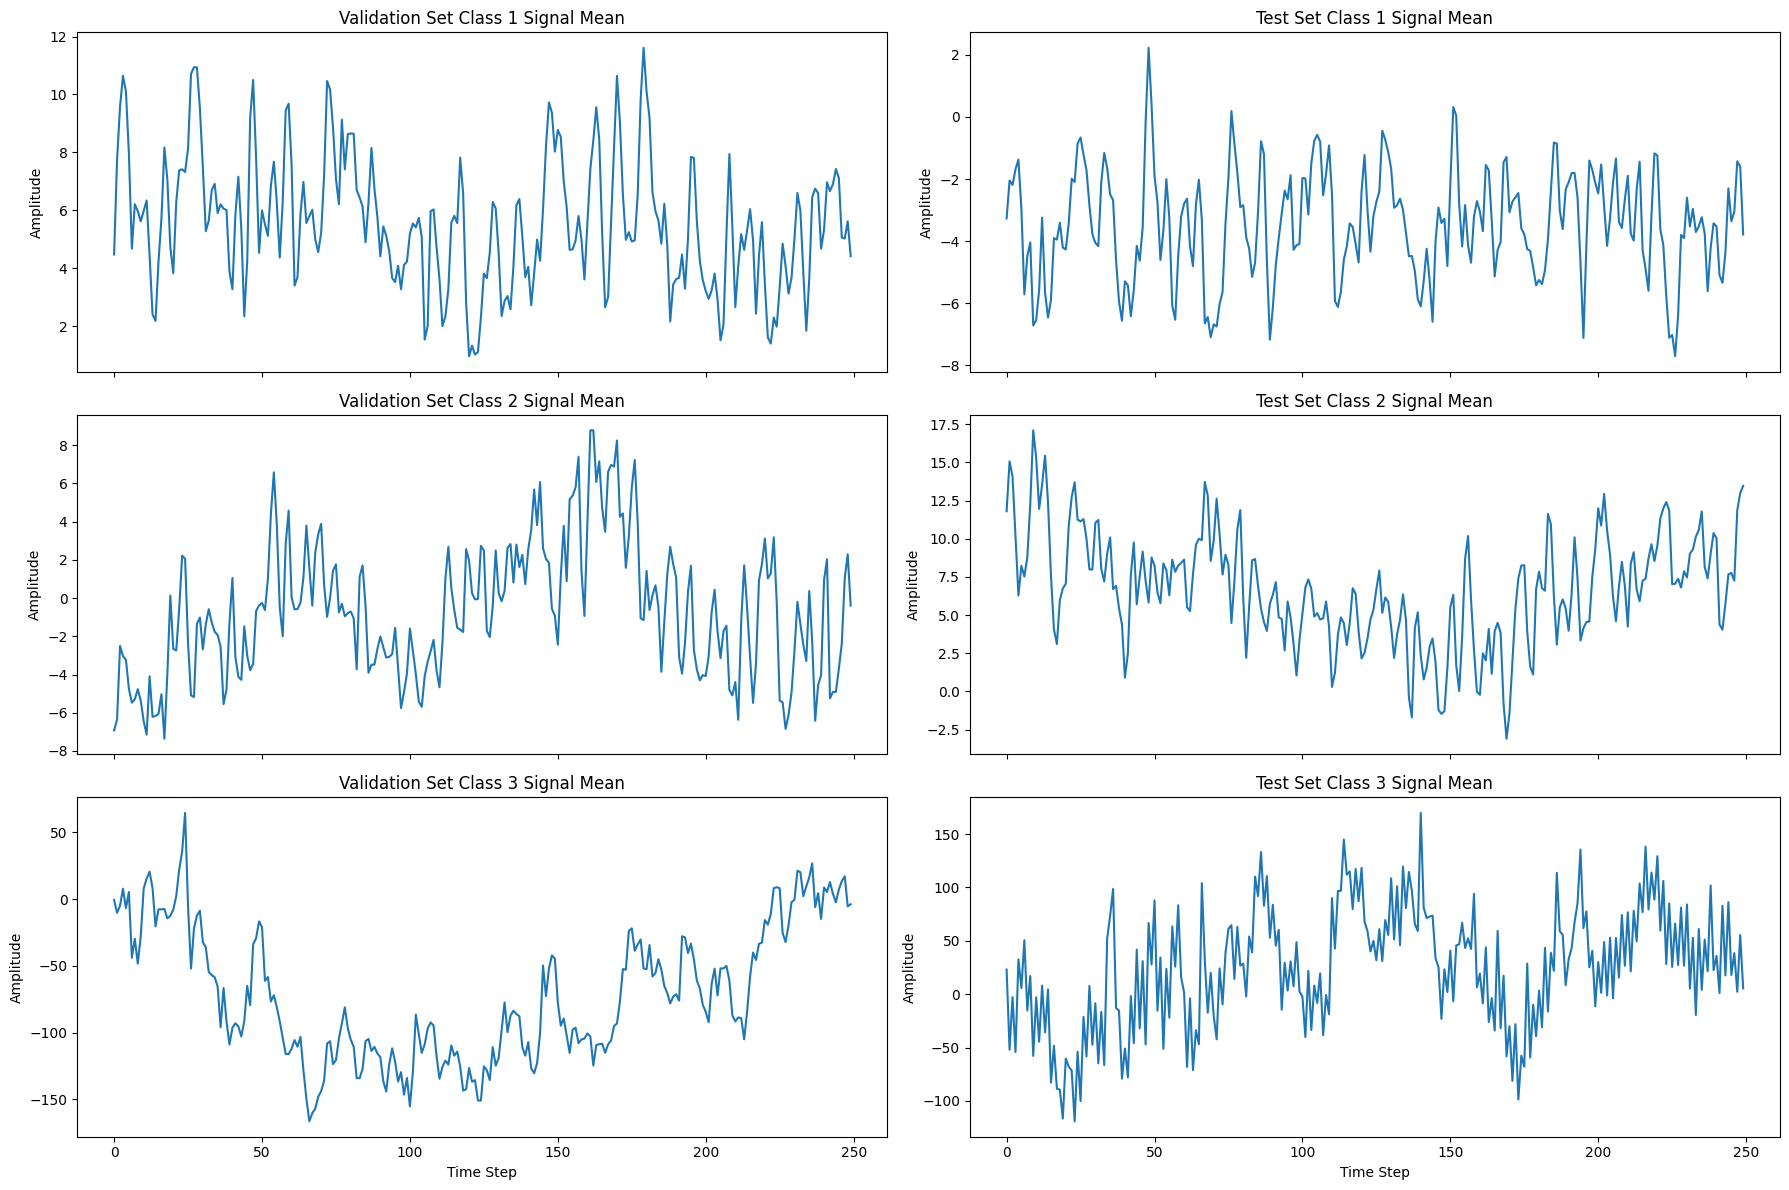

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(18, 12), sharex=True)

for i, class_label in enumerate([1, 2, 3]):
    val_mean = compute_mean_tensor(val_dataset, class_label=class_label)
    test_mean = compute_mean_tensor(test_dataset, class_label=class_label)
    
    if val_mean is not None:
        axs[i, 0].plot(val_mean.numpy())
        axs[i, 0].set_title(f"Validation Set Class {class_label} Signal Mean")
        axs[i, 0].set_ylabel("Amplitude")

    if test_mean is not None:
        axs[i, 1].plot(test_mean.numpy())
        axs[i, 1].set_title(f"Test Set Class {class_label} Signal Mean")
        axs[i, 1].set_ylabel("Amplitude")

# Set x-axis label on the bottom row
axs[2, 0].set_xlabel("Time Step")
axs[2, 1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()


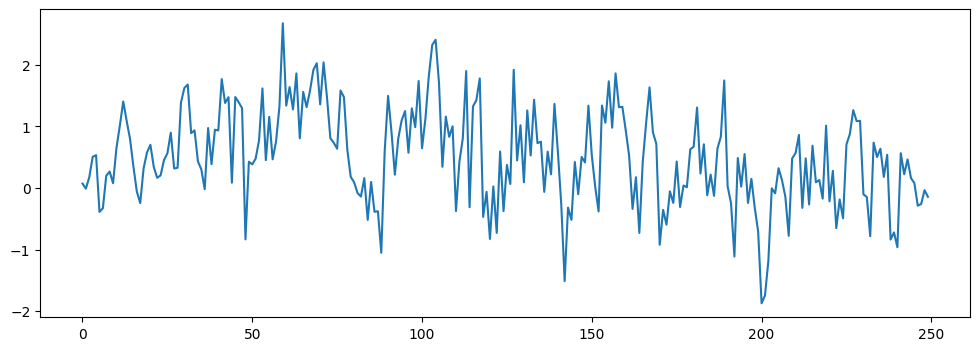

In [ ]:
from butqdb_dataloaders import TrainDataset
train_dataset = TrainDataset(
    data_path, train_records, window_size, signal_fs,
    transforms=transforms, stride=None, mode='random')

plt.figure(figsize=(12, 4))
plt.plot(compute_mean_tensor(train_dataset, class_label=None))